# SocialCops Data Science Intern Challenge

## Challenge: Agriculture Commodities, Prices & Seasons

**Aim:** Your team is working on building a variety of insight packs to measure key trends in the Agriculture sector in India. You are presented with a data set around Agriculture and your aim is to understand trends in APMC (Agricultural produce market committee)/mandi price & quantity arrival data for different commodities in Maharashtra.

**Objectives:**
* Test and filter outliers.
* Understand price fluctuations accounting the seasonal effect
    * Detect seasonality type (multiplicative or additive) for each cluster of APMC and commodities
    * De-seasonalise prices for each commodity and APMC according to the detected seasonality type
* Compare prices in APMC/Mandi with MSP(Minimum Support Price)- raw and deseasonalised
* Flag set of APMC/mandis and commodities with highest price fluctuation across different commodities in each relevant season, and year.


## Dataset Description

The agriculture data contains two files namely:
    * 'CMO_MSP_Mandi.csv' that contains Min. Support Prices (MSPs) and Crop Type for each commodity.
    * 'Monthly_data_cmo.csv' contains the APMC-wise monthly prices (min., max. and average) for each and every commodity.
    
**Variable description:**
* msprice- Minimum Support Price
* arrivals_in_qtl- Quantity arrival in market (in quintal)
* min_price- Minimum price charged per quintal
* max_price- Maximum price charged per quintal
* modal_price- Mode (Average) price charged per quintal

## Section 1: Exploratory Data Analysis

In [18]:
# Importing necessary modules.

import datetime
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

In [154]:
# Reading the dataset.

date_parse = lambda dates: pd.datetime.strptime(dates, '%Y')
df_mandi = pd.read_csv('./Mandi_Data/CMO_MSP_Mandi.csv', parse_dates=['year'], index_col='year', date_parser=date_parse)

print('Length of dataset: ', len(df_mandi))
print('Crops types:', set(df_mandi['Type']))
#df_mandi.loc[df_mandi['commodity'] == 'BAJRI']

Length of dataset:  155
Crops types: {'Other Crops', 'Kharif Crops', 'Rabi Crops'}


In [20]:
# Checking missing data values.

df_mandi.isna().sum()

commodity      0
Type           0
msprice       10
msp_filter     0
dtype: int64

The above missing values count demonstrates that MSP Prices are missing for 10 commodities in the Mandi dataset.

In [157]:
# Reading the dataset as a timeseries data.

date_parse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')
df_monthly = pd.read_csv('./Mandi_Data/Monthly_data_cmo.csv', parse_dates=['date'], index_col='date', date_parser=date_parse)

print('Length of dataset:', len(df_monthly), '\n')
#print(type(df_monthly['date']))
print(df_monthly.dtypes)

print('\nSet of unique district names:', set(df_monthly['district_name']))

df_monthly.head()

Length of dataset: 62429 

APMC               object
Commodity          object
Year                int64
Month              object
arrivals_in_qtl     int64
min_price           int64
max_price           int64
modal_price         int64
district_name      object
state_name         object
dtype: object

Set of unique district names: {'Buldhana', 'Gadchiroli', 'Aurangabad', 'Akola', 'Nasik', 'Chandrapur', 'Jalgaon', 'Nagpur', 'Beed', 'Kolhapur', 'Solapur', 'Nandurbar', 'Pune', 'Mumbai', 'Satara', 'Ratnagiri', 'Hingoli', 'Latur', 'Sangli', 'Parbhani', 'Wardha', 'Yewatmal', 'Osmanabad', 'Nanded', 'Dhule', 'Raigad', 'Ahmadnagar', 'Amaravathi', 'Jalna', 'Wasim', 'Thane', 'Gondiya', 'Bhandara'}


,APMC,Commodity,Year,Month,arrivals_in_qtl,min_price,max_price,modal_price,district_name,state_name
date,,,,,,,,,,
2015-04-01,Ahmednagar,Bajri,2015,April,79,1406,1538,1463,Ahmadnagar,Maharashtra
2016-04-01,Ahmednagar,Bajri,2016,April,106,1788,1925,1875,Ahmadnagar,Maharashtra
2015-04-01,Ahmednagar,Wheat(Husked),2015,April,1253,1572,1890,1731,Ahmadnagar,Maharashtra
2016-04-01,Ahmednagar,Wheat(Husked),2016,April,387,1750,2220,1999,Ahmadnagar,Maharashtra
2015-04-01,Ahmednagar,Sorgum(Jawar),2015,April,3825,1600,2200,1900,Ahmadnagar,Maharashtra


In [158]:
# Checking missing values.
print(df_monthly.isna().sum())

APMC               0
Commodity          0
Year               0
Month              0
arrivals_in_qtl    0
min_price          0
max_price          0
modal_price        0
district_name      0
state_name         0
dtype: int64


The above counts are all zeros. It demonstrates that there are no missing values in the monthly dataset for the commodities.

In [23]:
# Index values for df_monthly dataset.
df_monthly.index

DatetimeIndex(['2015-04-01', '2016-04-01', '2015-04-01', '2016-04-01',
               '2015-04-01', '2016-04-01', '2015-04-01', '2016-04-01',
               '2015-04-01', '2016-04-01',
               ...
               '2016-11-01', '2016-11-01', '2016-11-01', '2016-11-01',
               '2016-11-01', '2016-11-01', '2016-11-01', '2016-11-01',
               '2016-11-01', '2016-11-01'],
              dtype='datetime64[ns]', name='date', length=62429, freq=None)

In [159]:
print('Total number of Commodities:', len(set(df_monthly['Commodity'])))
print('Total number of APMCs:', len(set(df_monthly['APMC'])))

df_monthly.loc[(df_monthly['Commodity'] == 'Onion') & (df_monthly['APMC'] == 'Ahmednagar')]
df_monthly.head()

Total number of Commodities: 352
Total number of APMCs: 349


,APMC,Commodity,Year,Month,arrivals_in_qtl,min_price,max_price,modal_price,district_name,state_name
date,,,,,,,,,,
2015-04-01,Ahmednagar,Bajri,2015,April,79,1406,1538,1463,Ahmadnagar,Maharashtra
2016-04-01,Ahmednagar,Bajri,2016,April,106,1788,1925,1875,Ahmadnagar,Maharashtra
2015-04-01,Ahmednagar,Wheat(Husked),2015,April,1253,1572,1890,1731,Ahmadnagar,Maharashtra
2016-04-01,Ahmednagar,Wheat(Husked),2016,April,387,1750,2220,1999,Ahmadnagar,Maharashtra
2015-04-01,Ahmednagar,Sorgum(Jawar),2015,April,3825,1600,2200,1900,Ahmadnagar,Maharashtra


## Section 2: Visualizations & Outlier Detection

In [147]:
# Method to plot the boxplot for prices of the commodity and detect the outliers.

def plot_boxplot(df_commodity):
    plt.figure(figsize=(15, 6))
    ax = sns.boxplot(x=df_commodity.index.date, y=df_commodity['modal_price'], linewidth=2)
    #ax = sns.boxplot(x=df_commodity.index, y=df_commodity['max_price'], linewidth=2)
    #ax = sns.boxplot(x=df_commodity.index, y=df_commodity['min_price'], linewidth=2)
    
    plt.xticks(rotation=45)
    plt.xlabel('Date')
    plt.show()

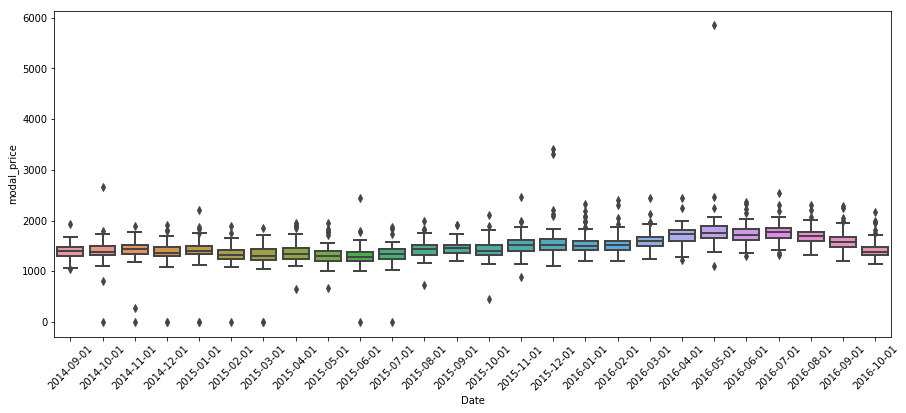

In [148]:
df_bajri = df_monthly.loc[df_monthly['Commodity'] == 'Bajri']
plot_boxplot(df_bajri)

The above **Box Plot** is for 'Bajri' commodity. It represents the average monthly prices for years: 2014, 2015 and 2016. The values in the rectangular box represent 1st, 2nd and 3rd Quartiles from bottom to up for every timestamp. The dark points away from the whiskers are outliers. For ex- In Mar 2016, the average price value (per quintal) is close to Rs. 6000 which is clearly an outlier.

Box Plot provides a very good visualization to find out the presence of outliers in the dataset.

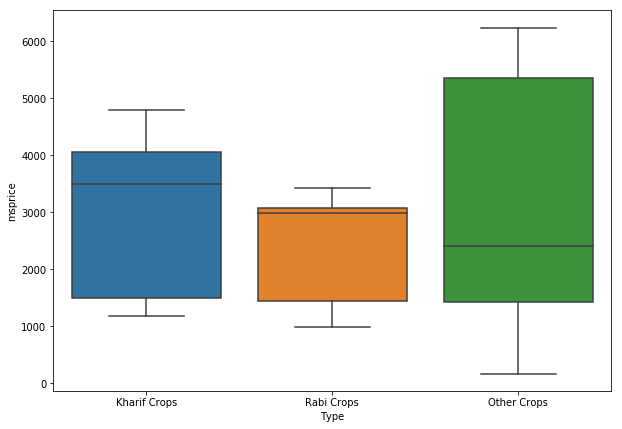

In [152]:
plt.figure(figsize=(10, 7))
ax = sns.boxplot(x='Type', y='msprice', data=df_mandi)

The above box plot for MSP (Min. Support Price) for various commodities evidents that there are no points outside the whiskers and hence, **no outliers** in the dataset: 'CMO_MSP_Mandi'.

## Section 3: Understanding price fluctuations accounting the seasonal effect

## Methodology:

Since there are total **352 commodities** and **349 APMCs** in the dataset, we have taken a sample of 3 APMCs: Ahmednagar, Rahata and Kamkhed and again, sample of 3 commodities: Bajri, Onion and Capsicum. But all the methods are written in a generic way so that the analysis can be easily extended to more number of APMCs and commodities just by calling these methods.

For each pair of commodity and APMC, we have done the following:
* Plot the monthly line graph for minimum, maximum and average prices of the commodity belonging to a given APMC to analyse the seasonality in the monthly prices.
* **Stationarity Test:** A time series is said to be stationary if its **statistical properties** such as mean and variance remain **constant over time**.
    * **Dickey Fuler Test:** It is one of the statistical tests for checking stationarity. Here, the null hypothesis is that the TS is non-stationary and alternate hypothesis is that the TS is stationary. The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. If the **‘Test Statistic’ is less than the ‘Critical Value’**, we can reject the null hypothesis and say that the time series is stationary.
* De-seasonalizing the time series (making the TS stationary):
    * There are 2 major reasons behind non-stationarity of a TS:
        1. **Trend** – varying mean over time.
        2. **Seasonality** – variations at specific time-frames.
    * So, we need to remove both trends and seasonality to make TS stationary.
* Removing the seasonality from the time series:
    * **Differencing with lag 1:** One of the most common methods of dealing with both trend and seasonality is differencing. In this technique, we take the difference of the observation at a particular instant with that at the previous instant.
    * **STR Decomposition:** STR refers to Seasonality, Trend and Residual. In this approach, trend and seasonality are modeled separately from TS data and residual part of the series becomes stationary.
* Comparison of APMC-wise commodity prices (max., average and min.) with MSPs: Line plots are plotted to clearly demonstrate how MSPs deviate largely from the average prices.

### APMCs and their Commodities

In [115]:
# Method to plot prices (max, min and average prices) corresponding to the given commodity and APMC.

def plot_prices(commodity, apmc):
    global df_monthly
    plt.figure(figsize=(15,5))

    plt.subplot(1, 3, 1)
    plt.plot(df_monthly.loc[(df_monthly['Commodity'] == commodity) & (df_monthly['APMC'] == apmc)]['min_price'])
    plt.ylabel('Min price')
    plt.xlabel('Months')
    plt.xticks(rotation=45)
    plt.title('Commodity = %s and APMC = %s' % (commodity, apmc))

    plt.subplot(1, 3, 2)
    plt.plot(df_monthly.loc[(df_monthly['Commodity'] == commodity) & (df_monthly['APMC'] == apmc)]['max_price'])
    plt.ylabel('Max price')
    plt.xlabel('Months')
    plt.xticks(rotation=45)

    plt.subplot(1, 3, 3)
    plt.plot(df_monthly.loc[(df_monthly['Commodity'] == commodity) & (df_monthly['APMC'] == apmc)]['modal_price'])
    plt.ylabel('Avg. price')
    plt.xlabel('Months')
    plt.xticks(rotation=45)

    plt.tight_layout()

### APMC: Ahmednagar and Commodities: Bajri, Onion and Capsicum

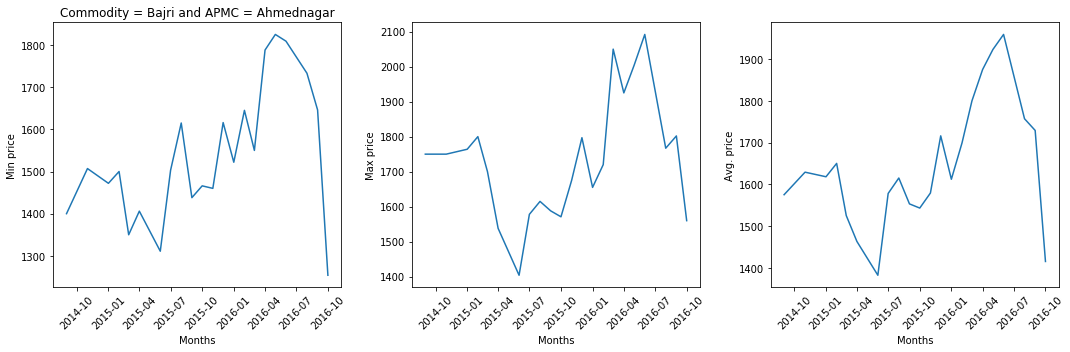

In [160]:
# Sort by index values (i.e. by dates).
df_monthly.sort_index(axis=0, inplace=True)

# Plot prices for different commodities in 'Ahmednagar' APMC.
plot_prices('Bajri', 'Ahmednagar')

The above plots clearly demonstrate rapid variations at specific time-frames. It is evident that the seasonality is yearly. However, it shows very mixed kind of seasonality (additive + multiplication).

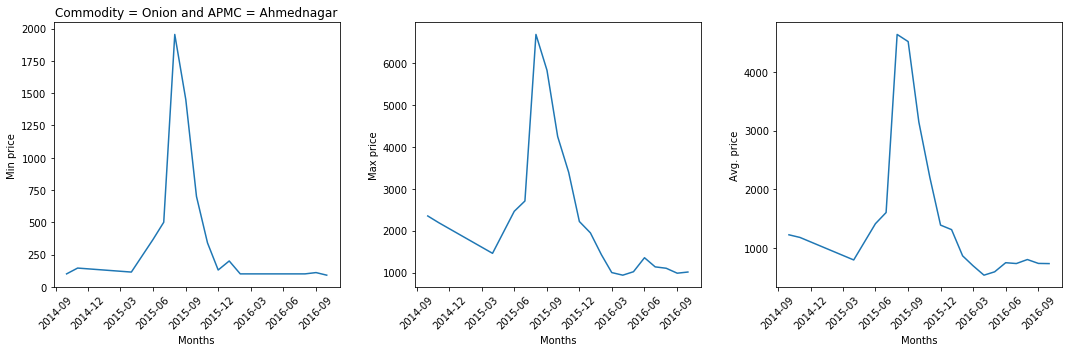

In [162]:
plot_prices('Onion', 'Ahmednagar')

The above plots clearly demonstrate a peak-shaped curve (surge) with peak around September' 2015 and rapid variations at specific time-frames. It is evident that the seasonality is yearly.

**Reason:** The main reason for this surge is **decreased supply**. Back in 2015, due to considerable **lower production of Onions**, supply had largely dropped. Consequently, the retail prices jumped. 

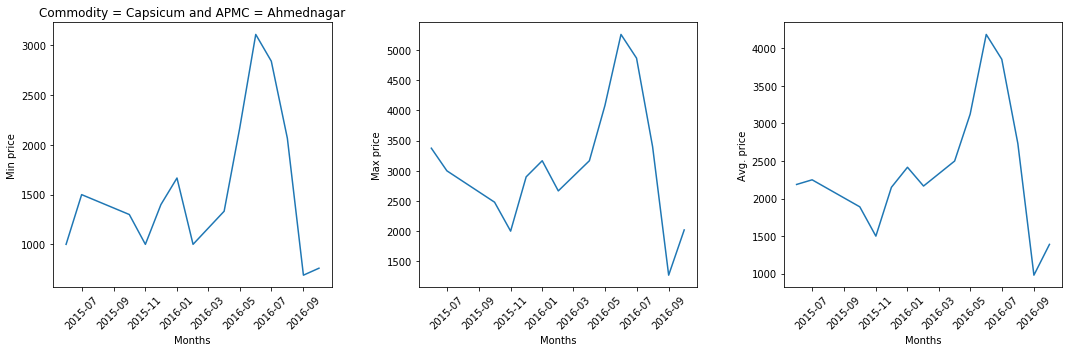

In [161]:
plot_prices('Capsicum', 'Ahmednagar')

The above plots clearly demonstrate rapid variations at specific time-frames. It is evident that the seasonality is yearly and seasonality type is **multiplicative**.

/Users/Technocrat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  
/Users/Technocrat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
  import sys


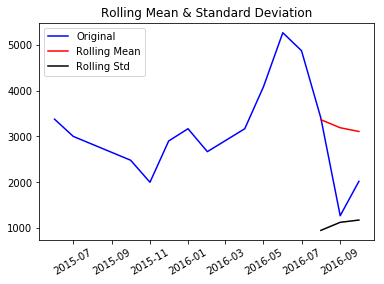

Results of Dickey-Fuller Test:
Test Statistic                -1.050151
p-value                        0.734536
#Lags Used                     4.000000
Number of Observations Used    9.000000
Critical Value (1%)           -4.473135
Critical Value (5%)           -3.289881
Critical Value (10%)          -2.772382
dtype: float64


In [165]:
# Method to test stationarity of the time series data using 'Dickey-Fuller Test'.

def test_stationarity(timeseries):
    
    # Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    # Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.xticks(rotation=30)
    plt.show(block=False)
    
    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
   
# Testing stationarity for APMC: Ahmednagar and Commodity: Bajri
test_stationarity(df_monthly.loc[(df_monthly['Commodity']=='Capsicum') & (df_monthly['APMC']=='Ahmednagar')]['max_price'])

**Analysis**: For the commodity 'Bajri' and APMC 'Ahmednagar', we applied 'Dickey Fuller Test' to test stationarity of the time series data for 'Modal (Average) price', 'Max price' and 'Min price' of the commodity. The full description of this test is above just under Section 3.

As **Test Stats < Critical Values**, we reject the Null Hypothesis and accept the Alternate Hypothesis to say that the time series is **stationary** for 'Avg' and 'Min' prices. Whereas for 'Max' prices, **Test Stats > Critical Values** (-1.05 > -2.77) and hence, we accept Null Hypothesis to say that the time series is **not stationary**. Here, the seasonality type is **Multiplicative**.

### Eliminating Seasonality using Differencing method

In [166]:
# Method to eliminate seasonality from the time series data via 'Differencing' method with lag 1.

def eliminate_seasonality(ts_log):
    ts_log_diff = ts_log - ts_log.shift()
    #plt.plot(ts_log_diff)

    ts_log_diff.dropna(inplace=True)
    test_stationarity(ts_log_diff)
    return ts_log_diff

### Using Decomposition to separate out trend, seasonality and residual 

In [167]:
# Method for applying 'Decomposition' on the original time series data to separate out trends and seasonality.

def decompose(ts_log):
    decomposition = seasonal_decompose(ts_log)

    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    plt.figure(figsize=(10, 5))
    plt.subplot(411)
    plt.plot(ts_log, label='Original')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residuals')
    plt.legend(loc='best')
    plt.tight_layout()

### APMC: Rahata and Commodities: Bajri, Onion and Capsicum

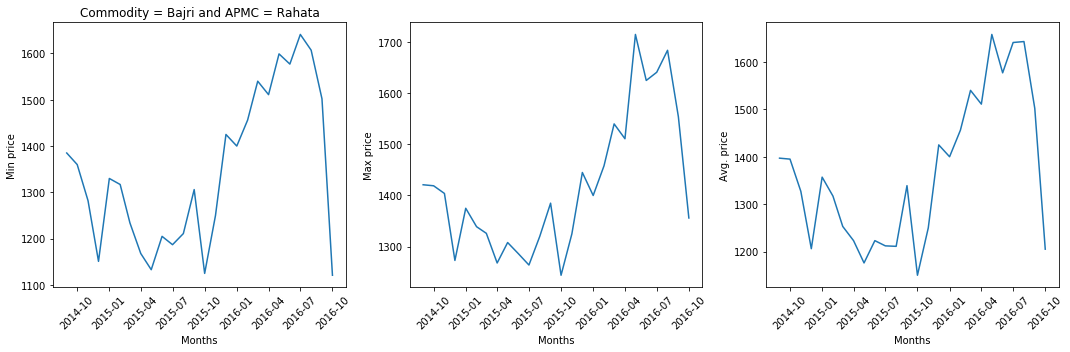

In [181]:
plot_prices('Bajri', 'Rahata')

The above plots clearly demonstrate rapid variations at specific time-frames. It is evident that the seasonality is yearly and seasonality type is **multiplicative**.

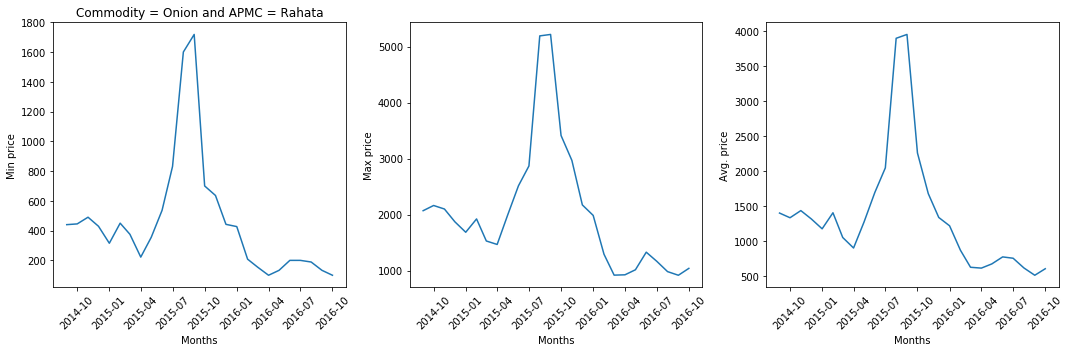

In [182]:
plot_prices('Onion', 'Rahata')

The above plots clearly demonstrate a peak-shaped curve (surge) with peak around September' 2015 and rapid variations at specific time-frames. It is evident that the seasonality is yearly.

**Reason:** The main reason for this surge is **decreased supply**. Back in 2015, due to considerable **lower production of Onions**, supply had largely dropped. Consequently, the retail prices jumped. It had affected Onion prices in all the APMCs not only in Maharashtra but also in India as a whole.

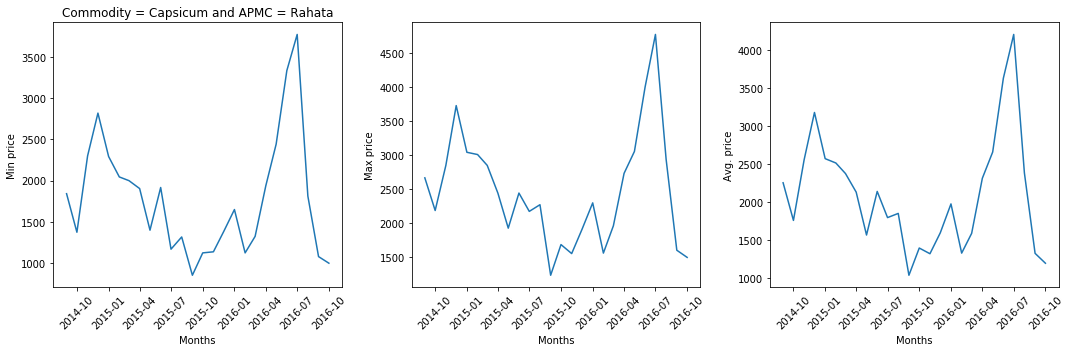

In [183]:
plot_prices('Capsicum', 'Rahata')

The above plots clearly demonstrate rapid variations at specific time-frames and hence, the TS has seasonal effects.

/Users/Technocrat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  
/Users/Technocrat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
  import sys


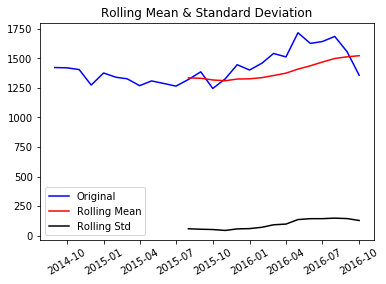

Results of Dickey-Fuller Test:
Test Statistic                 -2.616855
p-value                         0.089563
#Lags Used                      8.000000
Number of Observations Used    17.000000
Critical Value (1%)            -3.889266
Critical Value (5%)            -3.054358
Critical Value (10%)           -2.666984
dtype: float64


In [184]:
test_stationarity(df_monthly.loc[(df_monthly['Commodity']=='Bajri') & (df_monthly['APMC']=='Rahata')]['max_price'])

**Analysis:** For the commodity 'Bajri' and APMC 'Rahata', we applied 'Dickey Fuller Test' to test stationarity of the time series data for 'Modal (Average) price', 'Max price' and 'Min price' of the commodity.

As **Test Stats < Critical Values**, we reject the Null Hypothesis and accept the Alternate Hypothesis to say that the time series is **stationary** for 'Avg' and 'Min' prices. Whereas for 'Max' prices, **Test Stats > Critical Values** and hence, we accept Null Hypothesis to say that the time series is **not stationary**. Here, the seasonality type is **Multiplicative**.

## Eliminating Seasonality using Differencing method

/Users/Technocrat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  
/Users/Technocrat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
  import sys


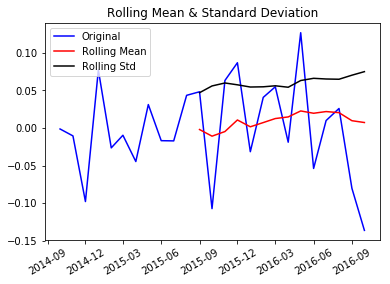

Results of Dickey-Fuller Test:
Test Statistic                 -2.737398
p-value                         0.067787
#Lags Used                      9.000000
Number of Observations Used    15.000000
Critical Value (1%)            -3.964443
Critical Value (5%)            -3.084908
Critical Value (10%)           -2.681814
dtype: float64


In [185]:
# Making time series for 'Max' prices stationary.
# Eliminating seasonality via Differencing method with lag 1.

# Take log of max prices since seasonality type is 'Multiplicative'.
ts_log = np.log(df_monthly.loc[(df_monthly['Commodity']=='Bajri') & (df_monthly['APMC']=='Rahata')]['max_price'])
ts_log_diff = eliminate_seasonality(ts_log)

**Analysis:** For max price value of the commodity 'Bajri', **Test Stats value is smaller than 10% Critical value**. It means the time series is **stationary with 90% confidence**.

Since the seasonality type was 'Multiplicative', we took **log transformation** of all the three prices to make them additive [since **log(u.v.w) = log(u) + log(v) + log(w)**] and then, applied **Differencing method** to de-seasonalize the prices.

### Applying STR Decomposition to separate out trends, seasonality and residuals. 

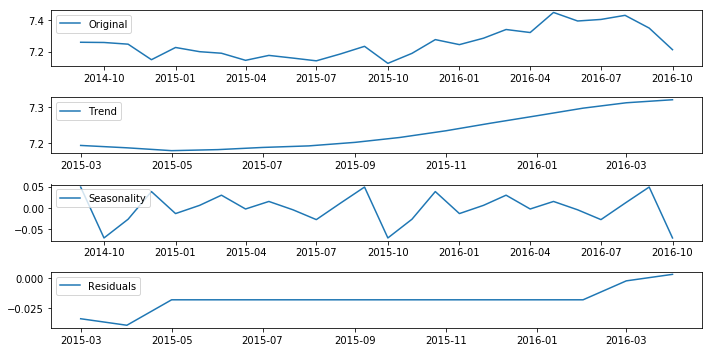

In [186]:
# STR Decomposition on APMC: Rahata and Commodity: Bajri
decompose(ts_log)

From STR Decomposition, trends and seasonality can be easily removed to get the residual de-seasonalized series.

### Comparison of APMC prices with Min. Support Prices of the commodities

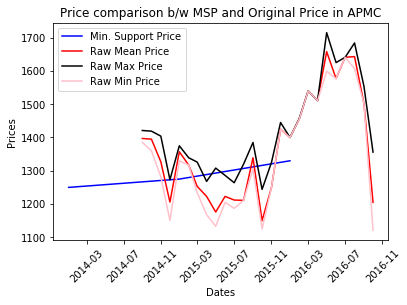

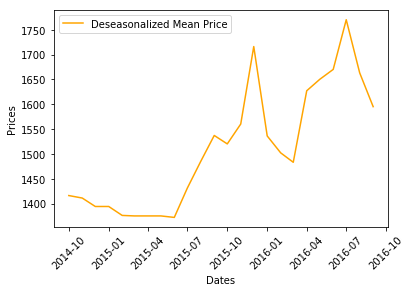

In [190]:
# Compare prices in APMC: Rahata with Minimum Support Price for the Commodity: Bajri

ts = df_monthly.loc[(df_monthly['Commodity']=='Bajri') & (df_monthly['APMC']=='Rahata')]
ts_mandi = df_mandi.loc[(df_mandi['commodity'] == 'BAJRI') & (df_mandi.index > datetime.datetime(2013, 12, 1))]

# Code to bring back the TS into its original domain.

ts_log_diff_cumsum = ts_log_diff.cumsum()

ts_pred_log = pd.Series(ts_log.ix[0], index=ts_log_diff.index)
#print(ts_pred_log.head())
ts_pred_log = ts_pred_log.add(ts_log_diff_cumsum, fill_value=0)

msp = plt.plot(ts_mandi['msprice'], color='blue', label='Min. Support Price')
orig_mean_price = plt.plot(ts['modal_price'], color='red', label='Raw Mean Price')
orig_max_price = plt.plot(ts['max_price'], color='black', label = 'Raw Max Price')
orig_min_price = plt.plot(ts['min_price'], color='pink', label = 'Raw Min Price')
#deseas_mean_price = plt.plot(ts_pred_log, color='orange', label = 'Deseas Mean Price')

plt.legend(loc='best')
plt.title('Price comparison b/w MSP and Original Price in APMC')
plt.xticks(rotation=45)
plt.ylabel('Prices')
plt.xlabel('Dates')
plt.show(block=False)


deseasonalized_ts_mean = (ts_pred_log)
plt.figure()
plt.plot(deseasonalized_ts_mean, color='orange', label = 'Deseasonalized Mean Price')
plt.legend(loc='best')
plt.xticks(rotation=45)
plt.ylabel('Prices')
plt.xlabel('Dates')
plt.show()

The above line plot is plotted to compare MSP prices for the commodity with its average prices over months.

**Analysis:** The blue line above for MSPs is below than other lines demonstrating max., average and min. prices of the commodity respectively from top to bottom in 2016. It shows that for the selected commodity, the minimum prices set by the Government are quite low and the prices at which the commodities are being sold at APMCs are soaring high in the sky.

The main reason for such a large price fluctuation between min. price set by the Government and actual price of the commodity in 2016 can be: **Very high transportation cost due to increase in the petrol/diesel prices**. It also depends on the geographical location of APMC. If it is near to the farming grounds, the cost is generally lower and very high in case the transportation cost is large for larger distances.

### APMC: Jamkhed and Commodities: Bajri and Onion

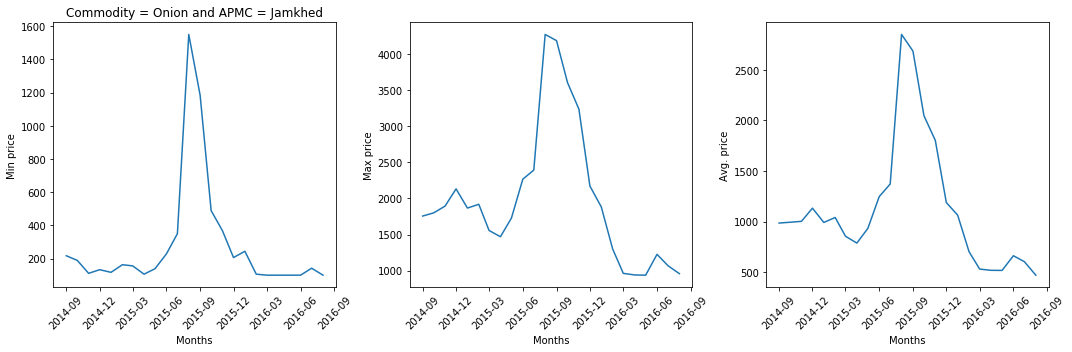

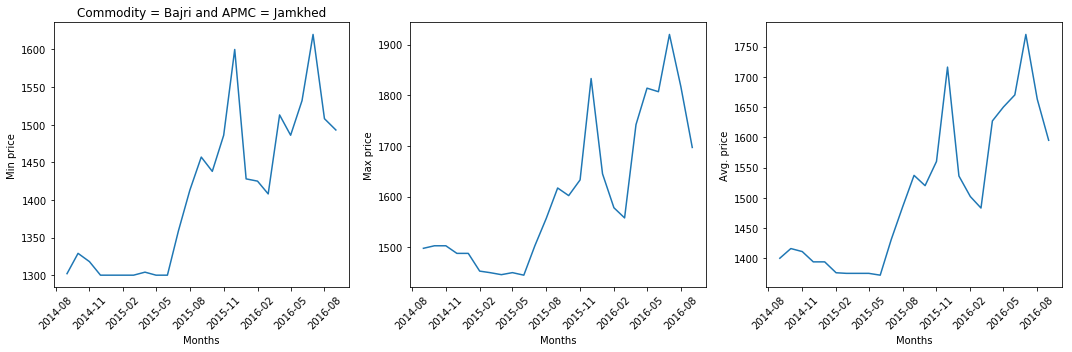

In [173]:
plot_prices('Onion', 'Jamkhed')
plot_prices('Bajri', 'Jamkhed')
#plot_prices('Capsicum', 'Jamkhed')

/Users/Technocrat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  
/Users/Technocrat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
  import sys


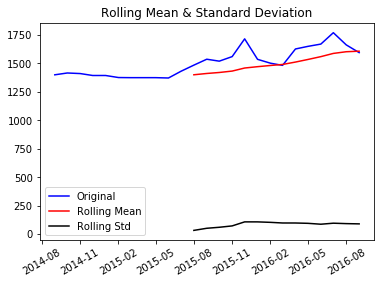

Results of Dickey-Fuller Test:
Test Statistic                 -1.450330
p-value                         0.557924
#Lags Used                      0.000000
Number of Observations Used    24.000000
Critical Value (1%)            -3.737709
Critical Value (5%)            -2.992216
Critical Value (10%)           -2.635747
dtype: float64


In [174]:
# Testing stationarity of the timeseries using 'Dickey-Fuller' test.
test_stationarity(df_monthly.loc[(df_monthly['Commodity']=='Bajri') & (df_monthly['APMC']=='Jamkhed')]['modal_price'])

**Analysis:** For the commodity 'Bajri' and APMC 'Jamkhed', we applied 'Dickey Fuller Test' to test stationarity of the time series data for 'Modal (Average) price', 'Max price' and 'Min price' of the commodity.

As **Test Stats > Critical Values**, we accept the Null Hypothesis to say that the time series is **not stationary** for all 'Avg', 'Max' and 'Min' prices. Here, the seasonality type is **Additive**.

## Eliminating Seasonality using Differencing method

/Users/Technocrat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  
/Users/Technocrat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
  import sys


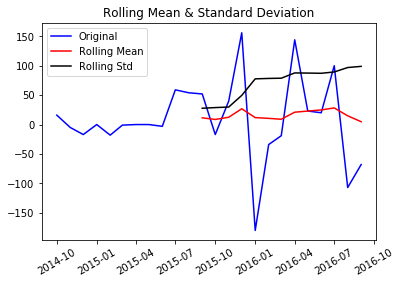

Results of Dickey-Fuller Test:
Test Statistic                 -3.331970
p-value                         0.013509
#Lags Used                      5.000000
Number of Observations Used    18.000000
Critical Value (1%)            -3.859073
Critical Value (5%)            -3.042046
Critical Value (10%)           -2.660906
dtype: float64
date
2014-09-01    1400
2014-10-01    1416
2014-11-01    1411
2014-12-01    1394
2015-01-01    1394
Name: modal_price, dtype: int64


date
2014-10-01    16.0
2014-11-01    -5.0
2014-12-01   -17.0
2015-01-01     0.0
2015-02-01   -18.0
Name: modal_price, dtype: float64

In [188]:
# Making time series for 'Max' prices stationary.
# Eliminating seasonality

ts_log = df_monthly.loc[(df_monthly['Commodity']=='Bajri') & (df_monthly['APMC']=='Jamkhed')]['modal_price']
ts_log_diff = eliminate_seasonality(ts_log)

print(ts_log.head())
ts_log_diff.head()

**Analysis:** Now **'Test Stats' value is less than the 5% Critical value**, we can surely say that the time series for: max, min and average prices for 'Bajri' commodity is **stationary** with **95% confidence** using 'Differencing' method. It means we have deseasonalized the prices for the commodity. 

### Applying STR Decomposition to separate out trends, seasonality and residuals. 

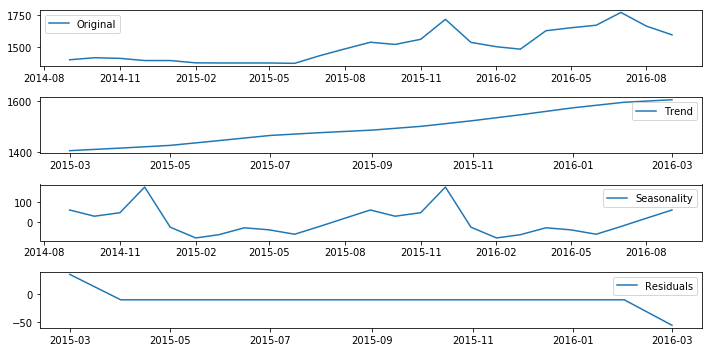

In [177]:
# Applying STR Decomposition for Commodity: Bajri and APMC: Jamkhed
decompose(ts_log)

### Comparison of APMC prices with Min. Support Prices of the commodities

/Users/Technocrat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # Remove the CWD from sys.path while we load stuff.


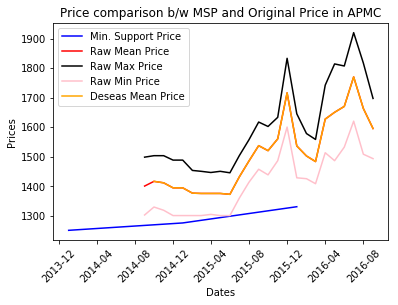

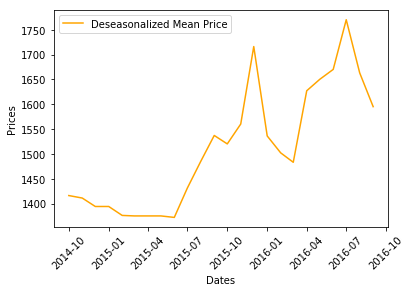

In [189]:
# Compare prices in APMC: Jamkhed with Minimum Support Price for the Commodity: Bajri

ts = df_monthly.loc[(df_monthly['Commodity']=='Bajri') & (df_monthly['APMC']=='Jamkhed')]
ts_mandi = df_mandi.loc[(df_mandi['commodity'] == 'BAJRI') & (df_mandi.index > datetime.datetime(2013, 12, 1))]

# Code to bring back the TS into its original domain.

ts_log_diff_cumsum = ts_log_diff.cumsum()

ts_pred_log = pd.Series(ts_log.ix[0], index=ts_log_diff.index)
#print(ts_pred_log.head())
ts_pred_log = ts_pred_log.add(ts_log_diff_cumsum, fill_value=0)

msp = plt.plot(ts_mandi['msprice'], color='blue', label='Min. Support Price')
orig_mean_price = plt.plot(ts['modal_price'], color='red', label='Raw Mean Price')
orig_max_price = plt.plot(ts['max_price'], color='black', label = 'Raw Max Price')
orig_min_price = plt.plot(ts['min_price'], color='pink', label = 'Raw Min Price')
deseas_mean_price = plt.plot(ts_pred_log, color='orange', label = 'Deseas Mean Price')

plt.legend(loc='best')
plt.title('Price comparison b/w MSP and Original Price in APMC')
plt.xticks(rotation=45)
plt.ylabel('Prices')
plt.xlabel('Dates')
plt.show(block=False)


deseasonalized_ts_mean = (ts_pred_log)
plt.figure()
plt.plot(deseasonalized_ts_mean, color='orange', label = 'Deseasonalized Mean Price')
plt.legend(loc='best')
plt.xticks(rotation=45)
plt.ylabel('Prices')
plt.xlabel('Dates')
plt.show()

The above line plot is plotted to compare MSP prices for the commodity with its average prices over months.

**Analysis:** The blue line above for MSPs is below than other lines demonstrating max., average and min. prices of the commodity respectively from top to bottom. It shows that for the selected commodity, the minimum prices set by the Government are quite low and the prices at which the commodities are being sold at APMCs are soaring high in the sky.

The main reason for such a large price fluctuation between min. price set by the Government and actual price of the commodity can be: **Very high transportation cost**. It also depends on the geographical location of APMC. If it is near to the farming grounds, the cost is generally lower and very high in case the transportation cost is large for larger distances.

## Section 4: Analyse price fluctuations across different commodities in each season and year

## Methodology

Since there are total **352 commodities** and **349 APMCs** in the dataset, we have taken a sample of 4 APMCs: Ahmednagar, Rahata, Jamkhed and Sangamner and again, sample of 4 commodities: Bajri, Onion, Capsicum and Soyabean. But all the methods are written in a generic way so that the analysis can be easily extended to more number of APMCs and commodities just by adding more commodities and APMCs in the list.

Firstly, we separated the whole dataset year-wise (i.e. for 2014, 2015 and 2016) to do yearly analysis.
* No. of entries for year 2016: 28971
* No. of entries for year 2015: 25557
* No. of entries for year 2014: 7901

For each year in [2014, 2015, 2016], we do the following:
* Plot line plot for maximum, average and minimum prices of the commodity for that year.
* Take difference of maximum price and minimum price of the commodity to get the **Maximum Price Fluctuation** in that year.
* Plot 2 bar plots (APMCs v/s Price Fluctuations and Commodities v/s Price Fluctuations) to visually analyse the max. Price Fluctuations corresponding to an APMC and Commodity for each year. 

In [44]:
# Different months in the dataset
set(df_monthly['Month'])

{'April',
 'August',
 'December',
 'February',
 'January',
 'July',
 'June',
 'March',
 'May',
 'November',
 'October',
 'September'}

In [62]:
# Number of records for each year: 2014, 2015, 2016.
df_2016 = df_monthly.loc[df_monthly['Year'] == 2016]
print('No. of records for year 2016:', len(df_2016))

df_2015 = df_monthly.loc[df_monthly['Year'] == 2015]
print('No. of records for year 2015:', len(df_2015))

df_2014 = df_monthly.loc[df_monthly['Year'] == 2014]
print('No. of records for year 2014:', len(df_2014))

No. of records for year 2016: 28971
No. of records for year 2015: 25557
No. of records for year 2014: 7901


In [100]:
# List of APMCs and Commodities whose price fluctuations (for each pair) we need to analyze.

apmcs = ['Ahmednagar', 'Rahata', 'Jamkhed', 'Sangamner']
commodities = ['Bajri', 'Onion', 'Capsicum', 'Soybean']

In [101]:
# Method to plot prices (max, min and average prices) corresponding to the given commodity and APMC.

def plot_prices_of_commodity(df, commodity, apmc):
    plt.figure(figsize=(15,5))

    plt.subplot(1, 3, 1)
    plt.plot(df['min_price'])
    plt.ylabel('Min price')
    plt.xlabel('Months')
    plt.xticks(rotation=45)
    plt.title('Commodity = %s and APMC = %s' % (commodity, apmc))

    plt.subplot(1, 3, 2)
    plt.plot(df['max_price'])
    plt.ylabel('Max price')
    plt.xticks(rotation=45)

    plt.subplot(1, 3, 3)
    plt.plot(df['modal_price'])
    plt.ylabel('Avg. price')
    plt.xticks(rotation=45)

    plt.tight_layout()

## Analyzing price fluctuations for 2016 year

Commodity: Bajri and APMC: Ahmednagar
Highest Price Fluctuation (per quintal): 544
Commodity: Bajri and APMC: Rahata
Highest Price Fluctuation (per quintal): 453
Commodity: Bajri and APMC: Jamkhed
Highest Price Fluctuation (per quintal): 287
Commodity: Bajri and APMC: Sangamner
Highest Price Fluctuation (per quintal): 457
Commodity: Onion and APMC: Ahmednagar
Highest Price Fluctuation (per quintal): 775
Commodity: Onion and APMC: Rahata
Highest Price Fluctuation (per quintal): 706
Commodity: Onion and APMC: Jamkhed
Highest Price Fluctuation (per quintal): 593
Commodity: Onion and APMC: Sangamner
Highest Price Fluctuation (per quintal): 659
Commodity: Capsicum and APMC: Ahmednagar
Highest Price Fluctuation (per quintal): 3206
Commodity: Capsicum and APMC: Rahata
Highest Price Fluctuation (per quintal): 3008
Commodity: Soybean and APMC: Ahmednagar
Highest Price Fluctuation (per quintal): 1190
Commodity: Soybean and APMC: Rahata
Highest Price Fluctuation (per quintal): 1208
Commodity: Soy

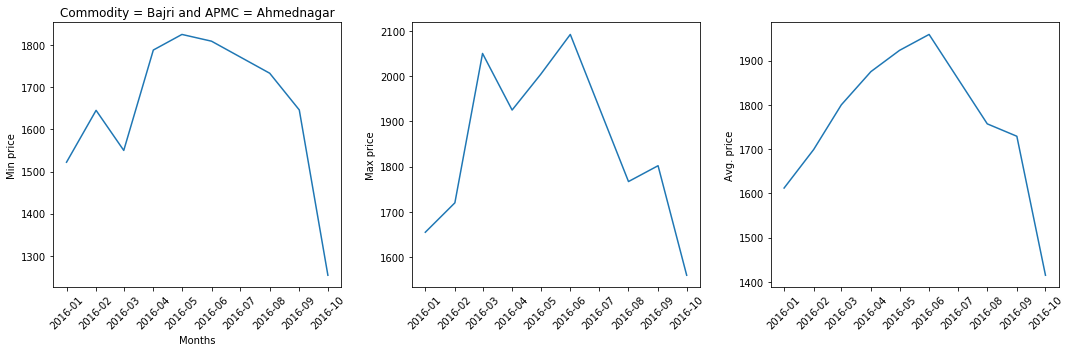

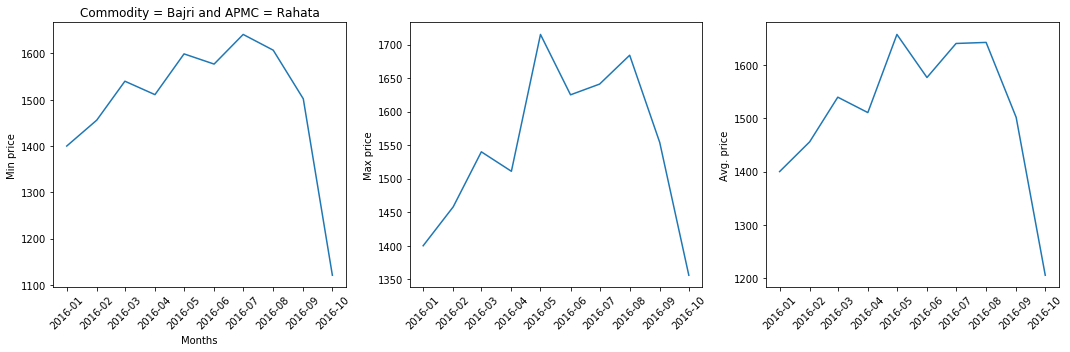

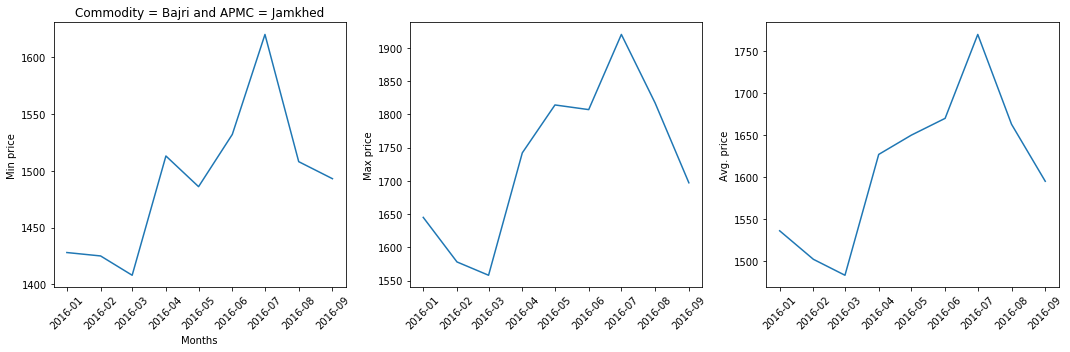

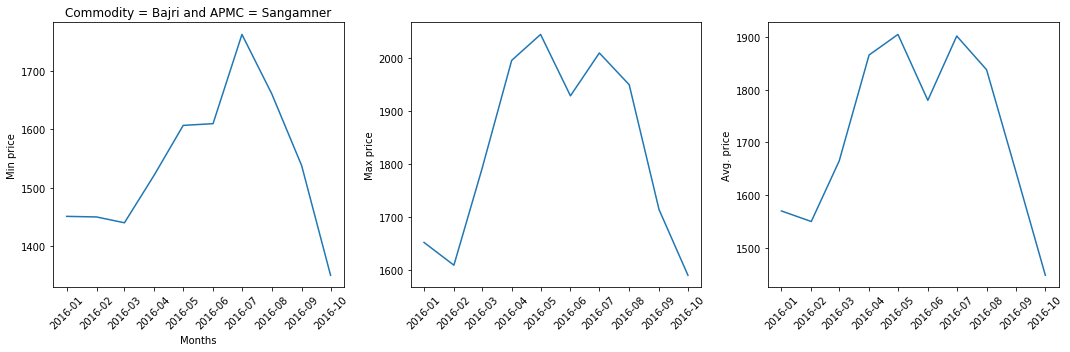

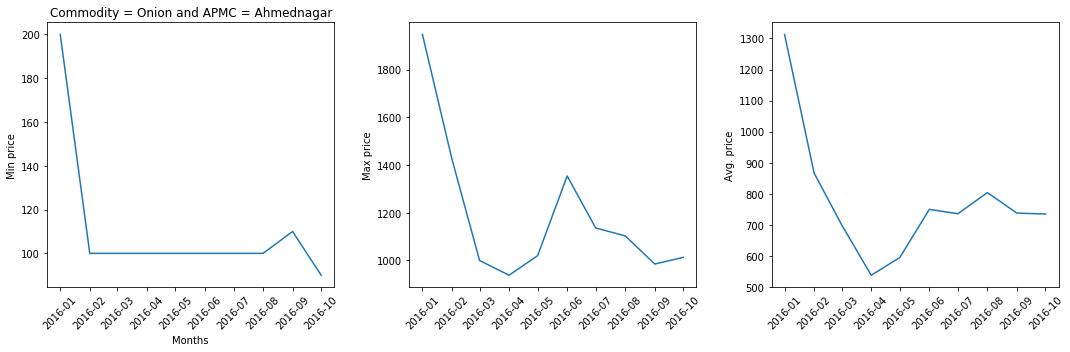

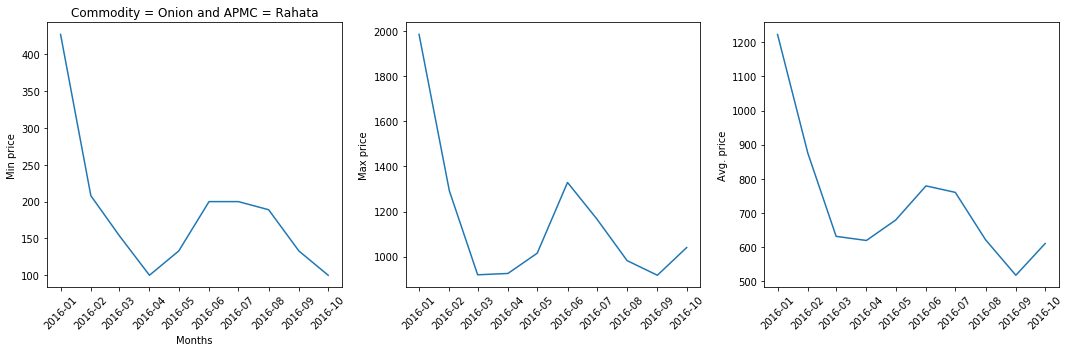

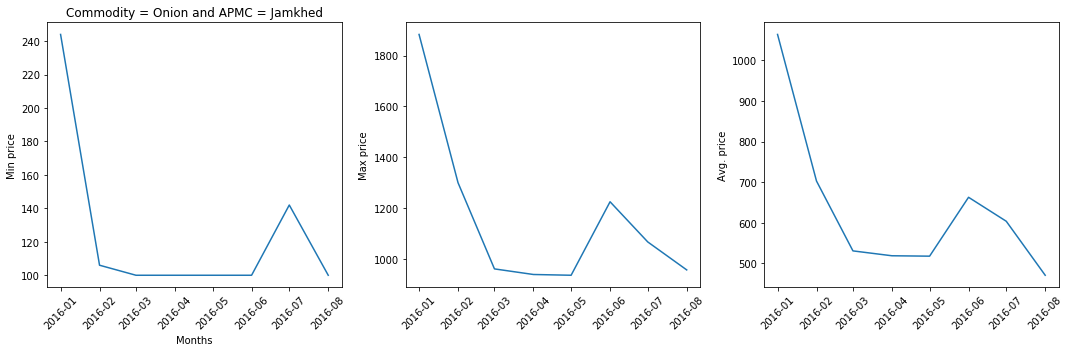

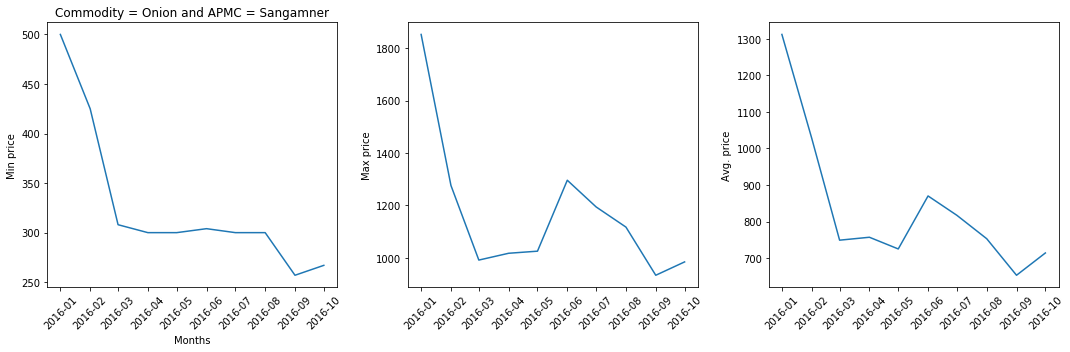

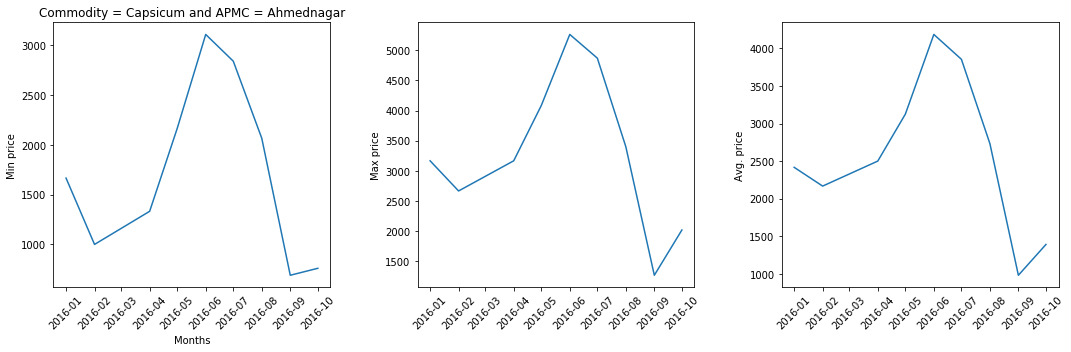

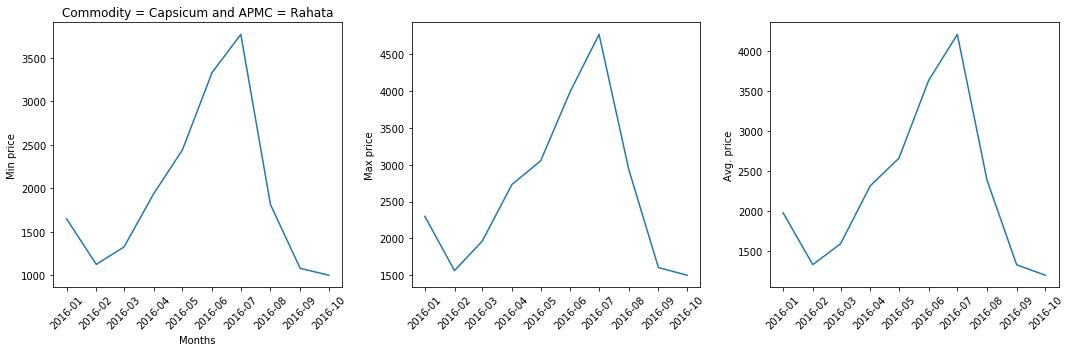

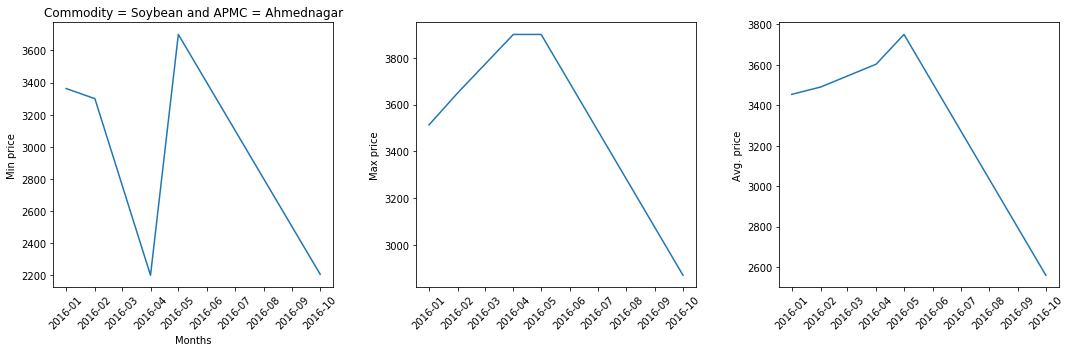

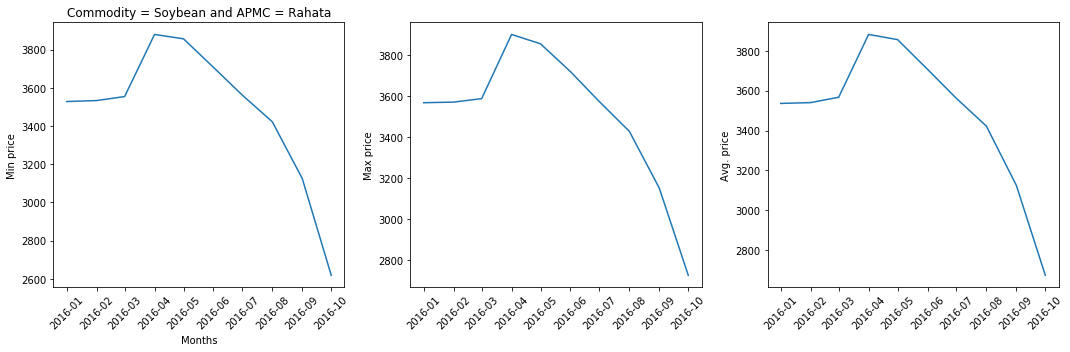

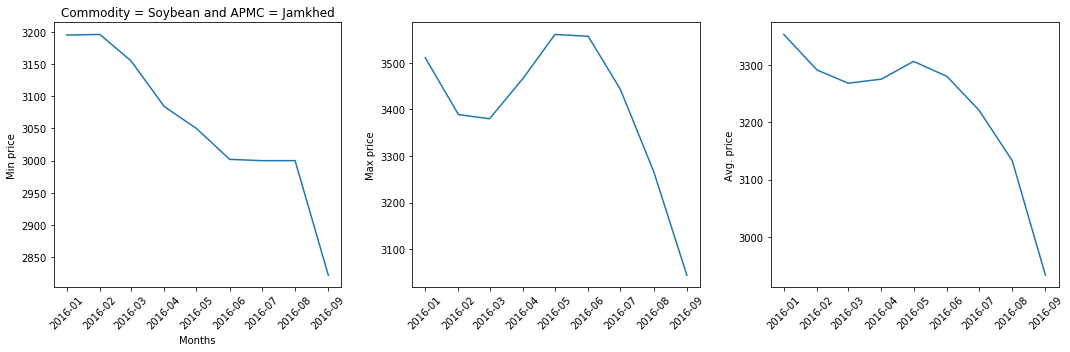

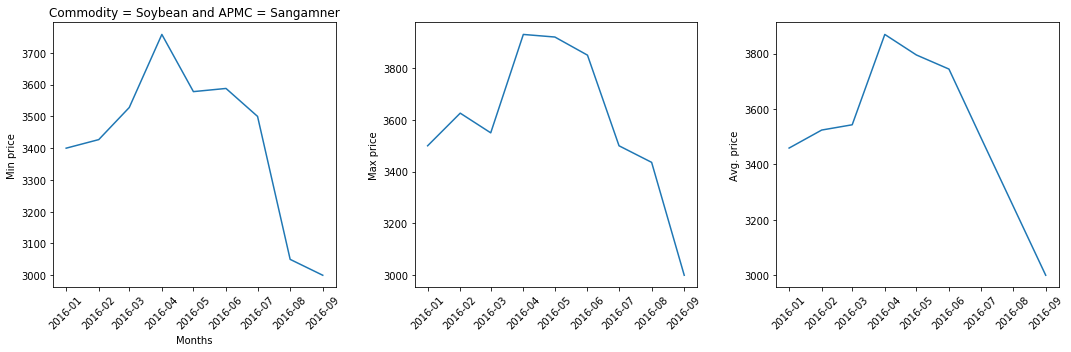

In [102]:
comm_fluctuations = {}
apmc_fluctuations = {}

# For each pair of commodity and APMC, this method computes the Highest Price Fluctuations for the year 2016 by
# differencing the maximum and minimum prices across different months of the year to get the max. price fluctuation.

for c in commodities:
    for apmc in apmcs:
        df_2016_filt = df_2016.query("Commodity=='%s' and APMC=='%s'" % (c, apmc))
        if len(df_2016_filt) == 0:
            continue
        plot_prices_of_commodity(df_2016_filt, c, apmc)
        avg_prices = df_2016_filt['modal_price']
        print('Commodity: %s and APMC: %s' % (c, apmc))
        print('Highest Price Fluctuation (per quintal): %d' % (max(avg_prices) - min(avg_prices)))
        
        if c not in comm_fluctuations:
            comm_fluctuations.update({c: max(avg_prices) - min(avg_prices)})
        else:
            comm_fluctuations[c] = max(comm_fluctuations[c], max(avg_prices) - min(avg_prices))
            
        if apmc not in apmc_fluctuations:
            apmc_fluctuations.update({apmc: max(avg_prices) - min(avg_prices)})
        else:
            apmc_fluctuations[apmc] = max(apmc_fluctuations[apmc], max(avg_prices) - min(avg_prices))

In [103]:
print(apmc_fluctuations)
print(comm_fluctuations)

{'Ahmednagar': 3206, 'Rahata': 3008, 'Jamkhed': 593, 'Sangamner': 869}
{'Bajri': 544, 'Onion': 775, 'Capsicum': 3206, 'Soybean': 1208}


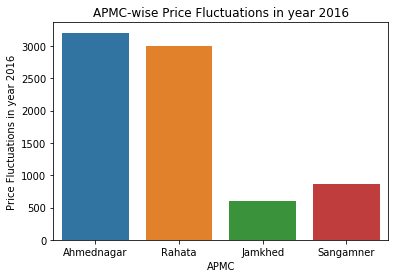

In [104]:
# Visualize Price Fluctuations based on APMCs.

ax = sns.barplot(x = list(apmc_fluctuations.keys()), y = list(apmc_fluctuations.values()))
plt.title('APMC-wise Price Fluctuations in year 2016')
plt.xlabel('APMC')
plt.ylabel('Price Fluctuations in year 2016')
plt.show()

**Analysis:** The above bar plot demonstrates that Ahmednagar APMC suffers from maximum Price Fluctuations in the year 2016.

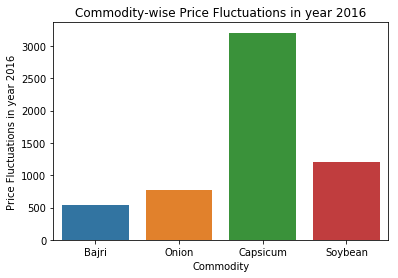

In [105]:
# Visualize Price Fluctuations based on Commodities.

ax = sns.barplot(x = list(comm_fluctuations.keys()), y = list(comm_fluctuations.values()))
plt.title('Commodity-wise Price Fluctuations in year 2016')
plt.xlabel('Commodity')
plt.ylabel('Price Fluctuations in year 2016')
plt.show()

**Analysis:** The above bar plot demonstrates that Capsicum commodity suffers from maximum Price Fluctuations in the year 2016.

So, we can conclude that **APMC: Ahmednagar and Commodity: Capsicum suffer from the highest Price Fluctuations**.

## Analyzing price fluctuations for 2015 year

Commodity: Bajri and APMC: Ahmednagar
Highest Price Fluctuation (per quintal): 334
Commodity: Bajri and APMC: Rahata
Highest Price Fluctuation (per quintal): 275
Commodity: Bajri and APMC: Jamkhed
Highest Price Fluctuation (per quintal): 344
Commodity: Bajri and APMC: Sangamner
Highest Price Fluctuation (per quintal): 104
Commodity: Onion and APMC: Ahmednagar
Highest Price Fluctuation (per quintal): 3838
Commodity: Onion and APMC: Rahata
Highest Price Fluctuation (per quintal): 3049
Commodity: Onion and APMC: Jamkhed
Highest Price Fluctuation (per quintal): 2062
Commodity: Onion and APMC: Sangamner
Highest Price Fluctuation (per quintal): 2579
Commodity: Capsicum and APMC: Ahmednagar
Highest Price Fluctuation (per quintal): 750
Commodity: Capsicum and APMC: Rahata
Highest Price Fluctuation (per quintal): 1533
Commodity: Soybean and APMC: Ahmednagar
Highest Price Fluctuation (per quintal): 443
Commodity: Soybean and APMC: Rahata
Highest Price Fluctuation (per quintal): 436
Commodity: So

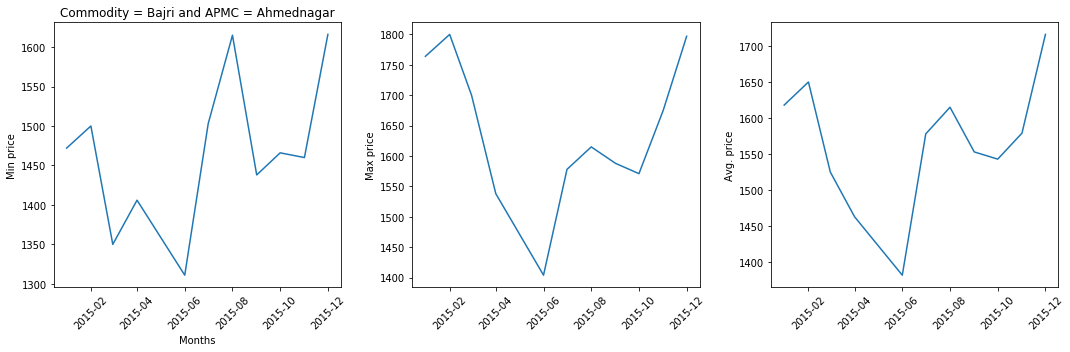

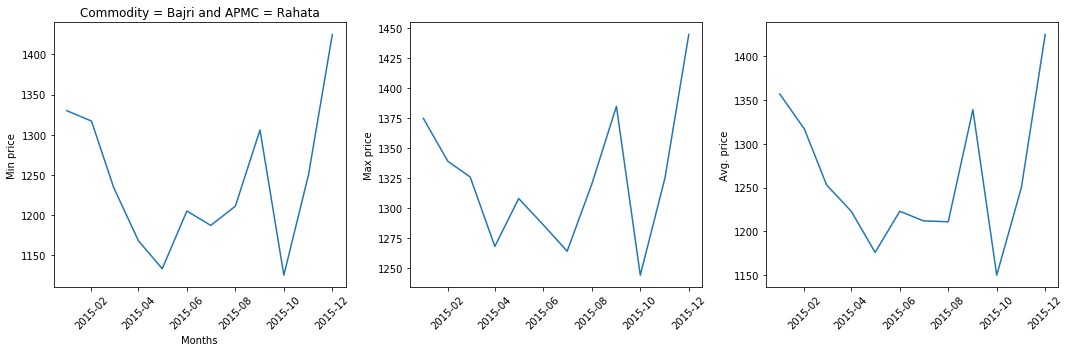

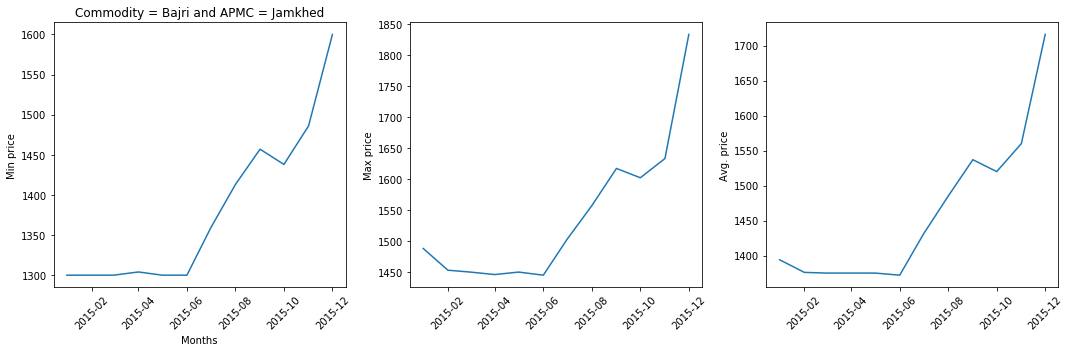

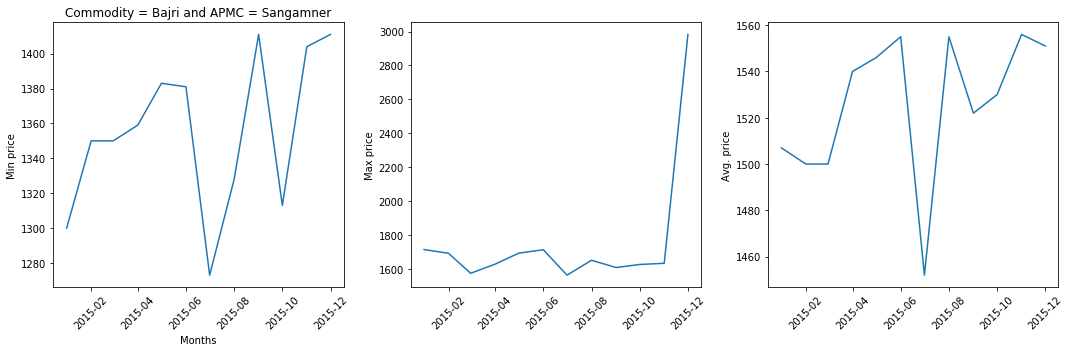

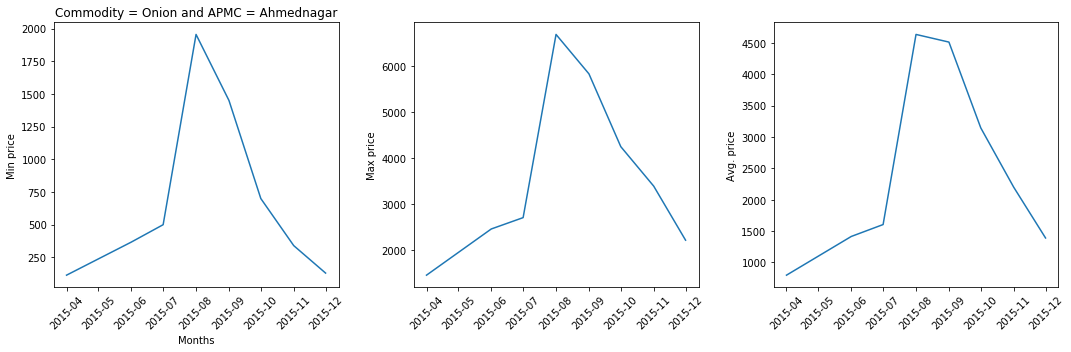

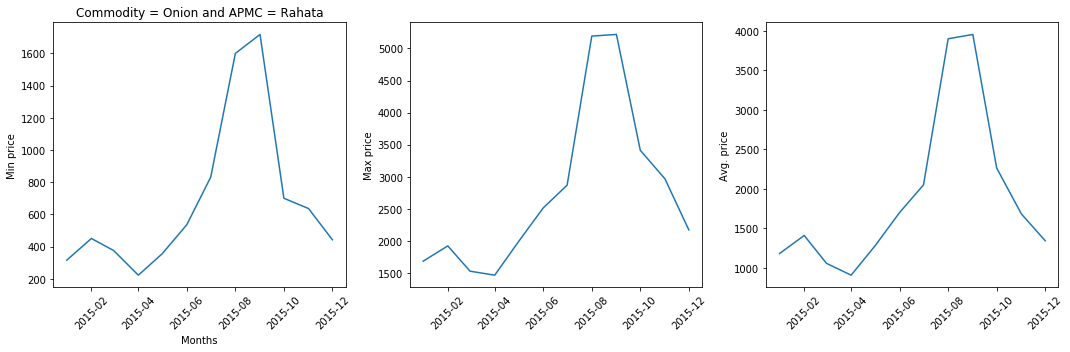

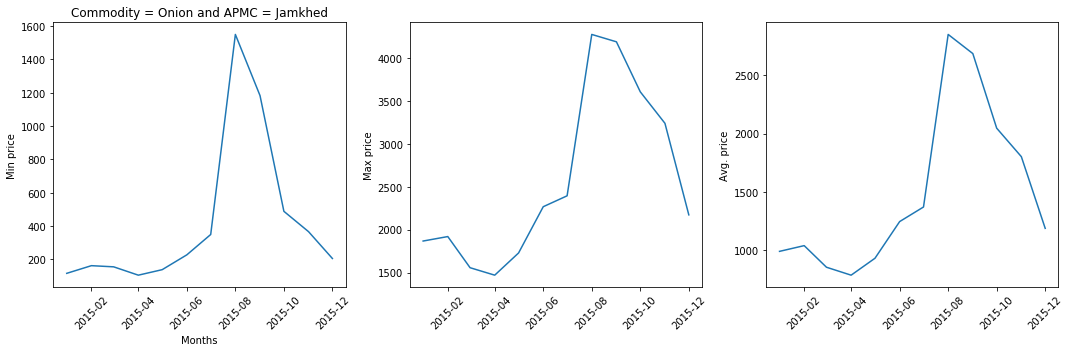

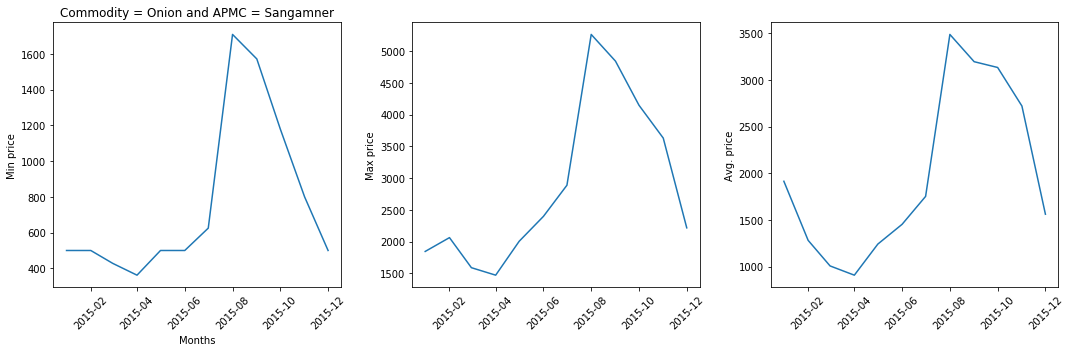

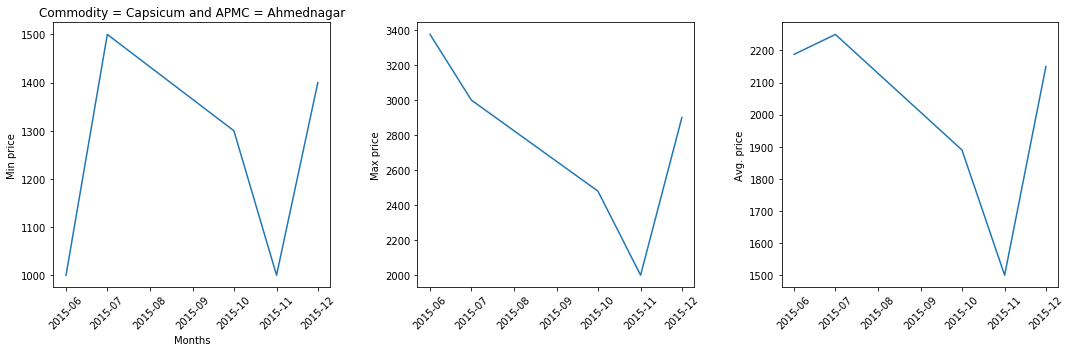

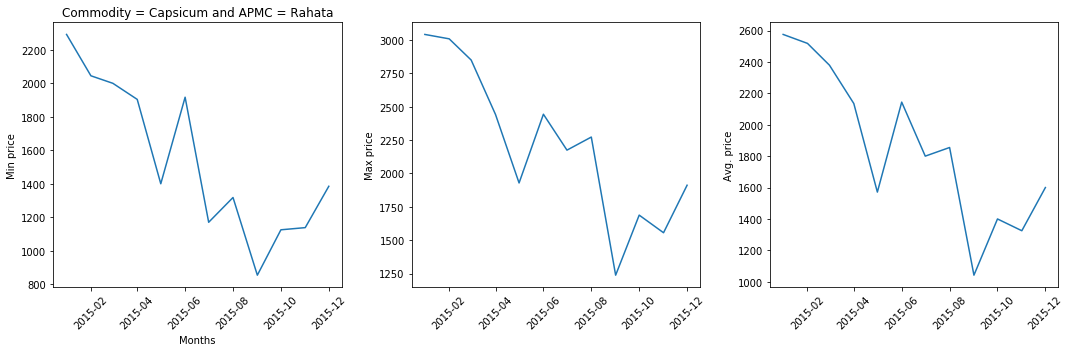

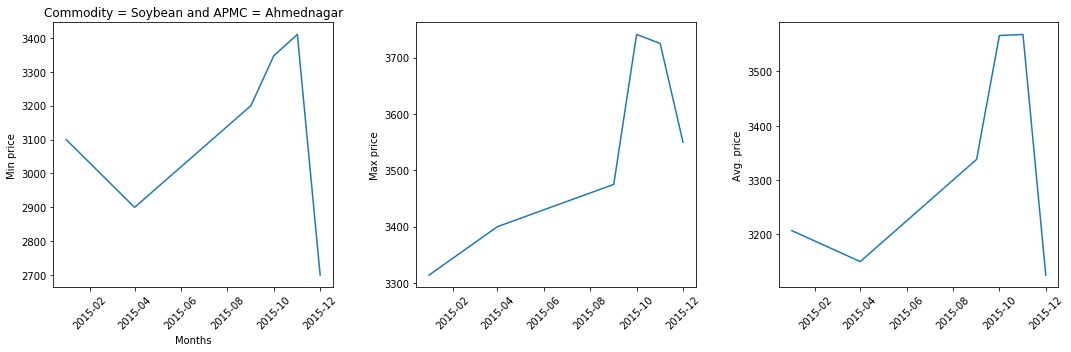

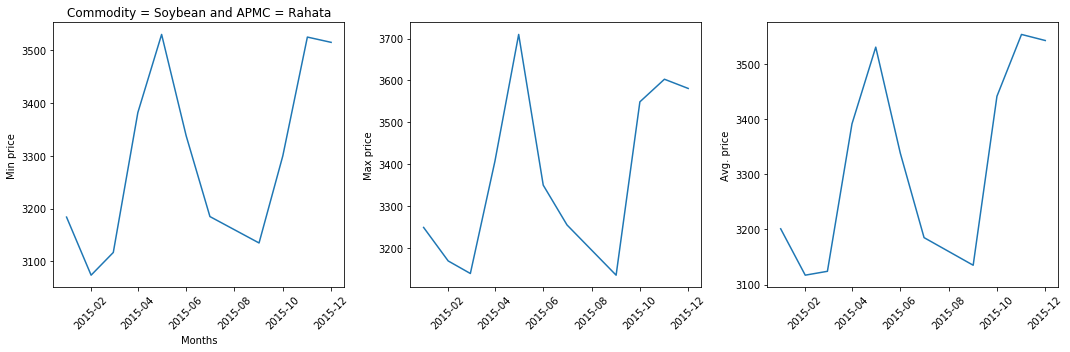

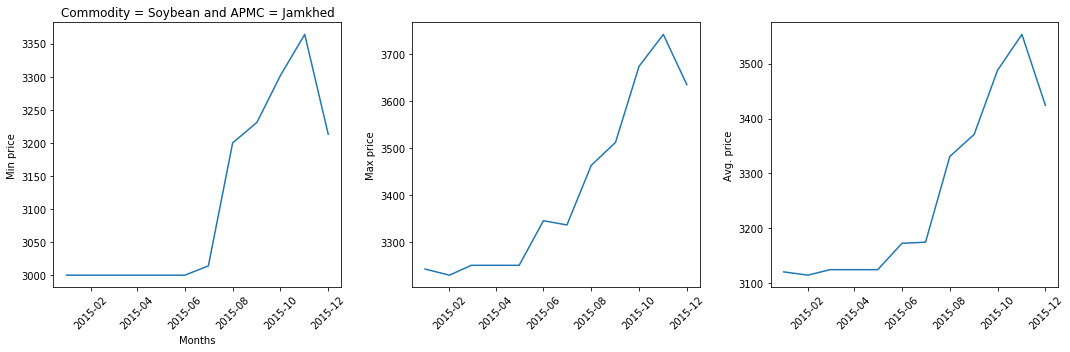

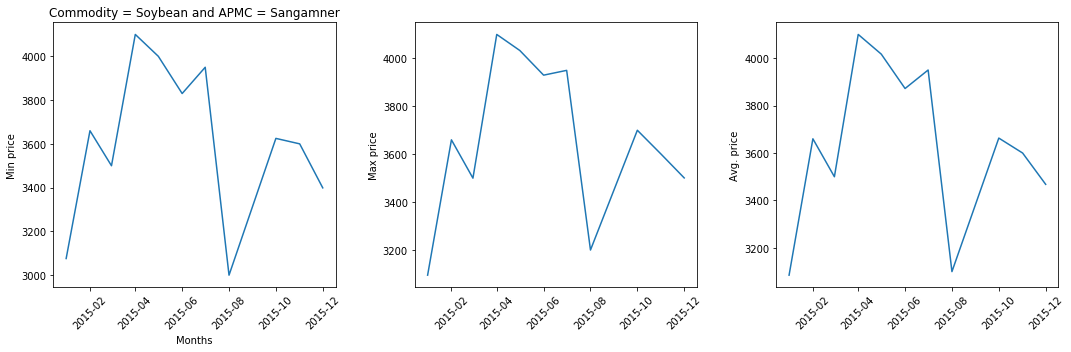

In [106]:
comm_fluctuations = {}
apmc_fluctuations = {}

# For each pair of commodity and APMC, this method computes the Highest Price Fluctuations for the year 2015 by
# differencing the maximum and minimum prices across different months of the year to get the max. price fluctuation.

for c in commodities:
    for apmc in apmcs:
        df_2015_filt = df_2015.query("Commodity=='%s' and APMC=='%s'" % (c, apmc))
        if len(df_2015_filt) == 0:
            continue
        plot_prices_of_commodity(df_2015_filt, c, apmc)
        avg_prices = df_2015_filt['modal_price']
        print('Commodity: %s and APMC: %s' % (c, apmc))
        print('Highest Price Fluctuation (per quintal): %d' % (max(avg_prices) - min(avg_prices)))
        
        if c not in comm_fluctuations:
            comm_fluctuations.update({c: max(avg_prices) - min(avg_prices)})
        else:
            comm_fluctuations[c] = max(comm_fluctuations[c], max(avg_prices) - min(avg_prices))
            
        if apmc not in apmc_fluctuations:
            apmc_fluctuations.update({apmc: max(avg_prices) - min(avg_prices)})
        else:
            apmc_fluctuations[apmc] = max(apmc_fluctuations[apmc], max(avg_prices) - min(avg_prices))

In [107]:
print(apmc_fluctuations)
print(comm_fluctuations)

{'Ahmednagar': 3838, 'Rahata': 3049, 'Jamkhed': 2062, 'Sangamner': 2579}
{'Bajri': 344, 'Onion': 3838, 'Capsicum': 1533, 'Soybean': 1015}


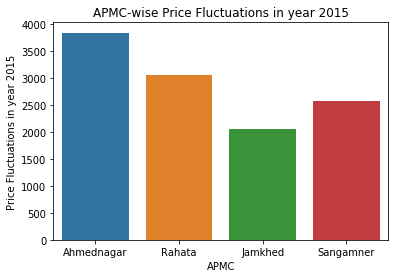

In [108]:
# Visualize Price Fluctuations based on APMCs.

ax = sns.barplot(x = list(apmc_fluctuations.keys()), y = list(apmc_fluctuations.values()))
plt.title('APMC-wise Price Fluctuations in year 2015')
plt.xlabel('APMC')
plt.ylabel('Price Fluctuations in year 2015')
plt.show()

**Analysis:** The above bar plot demonstrates that Ahmednagar APMC suffers from maximum Price Fluctuations in the year 2015.

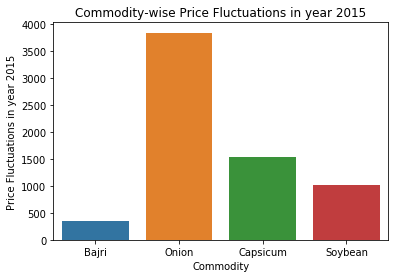

In [109]:
# Visualize Price Fluctuations based on Commodities.

ax = sns.barplot(x = list(comm_fluctuations.keys()), y = list(comm_fluctuations.values()))
plt.title('Commodity-wise Price Fluctuations in year 2015')
plt.xlabel('Commodity')
plt.ylabel('Price Fluctuations in year 2015')
plt.show()

**Analysis:** The above bar plot demonstrates that Onion commodity suffers from maximum Price Fluctuations in the year 2015. It is quite an expected result because we have already seen that due to **very less supply of Onions** in the market, the **retail prices soared high** in the sky across different APMCs in the country. 

So, we can conclude that **APMC: Ahmednagar and Commodity: Onion suffer from the highest Price Fluctuations**.

## Analyzing price fluctuations for 2014 year

Commodity: Bajri and APMC: Ahmednagar
Highest Price Fluctuation (per quintal): 54
Commodity: Bajri and APMC: Rahata
Highest Price Fluctuation (per quintal): 191
Commodity: Bajri and APMC: Jamkhed
Highest Price Fluctuation (per quintal): 22
Commodity: Bajri and APMC: Sangamner
Highest Price Fluctuation (per quintal): 122
Commodity: Onion and APMC: Ahmednagar
Highest Price Fluctuation (per quintal): 45
Commodity: Onion and APMC: Rahata
Highest Price Fluctuation (per quintal): 119
Commodity: Onion and APMC: Jamkhed
Highest Price Fluctuation (per quintal): 147
Commodity: Onion and APMC: Sangamner
Highest Price Fluctuation (per quintal): 58
Commodity: Capsicum and APMC: Rahata
Highest Price Fluctuation (per quintal): 1419
Commodity: Soybean and APMC: Ahmednagar
Highest Price Fluctuation (per quintal): 0
Commodity: Soybean and APMC: Rahata
Highest Price Fluctuation (per quintal): 350
Commodity: Soybean and APMC: Jamkhed
Highest Price Fluctuation (per quintal): 194
Commodity: Soybean and APMC

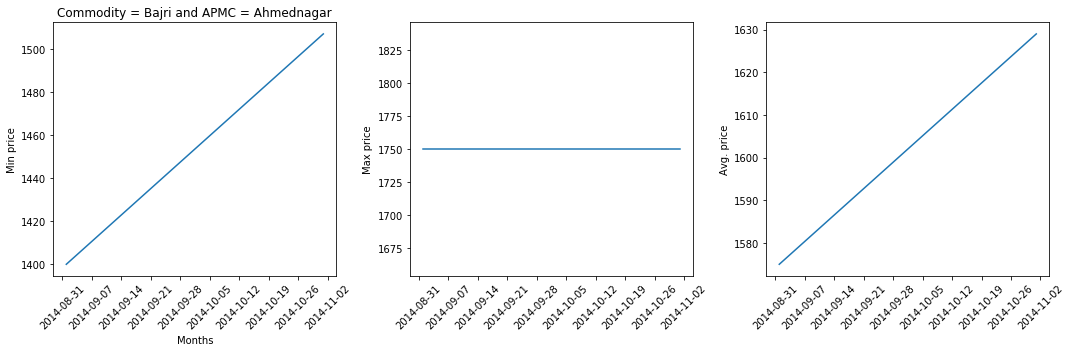

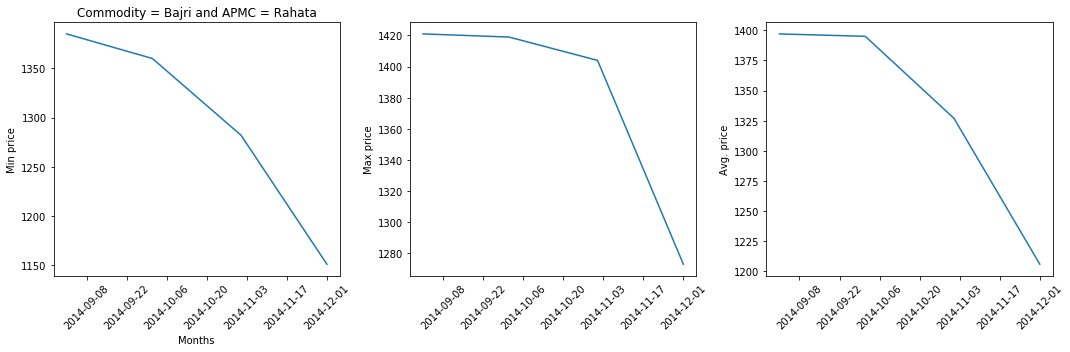

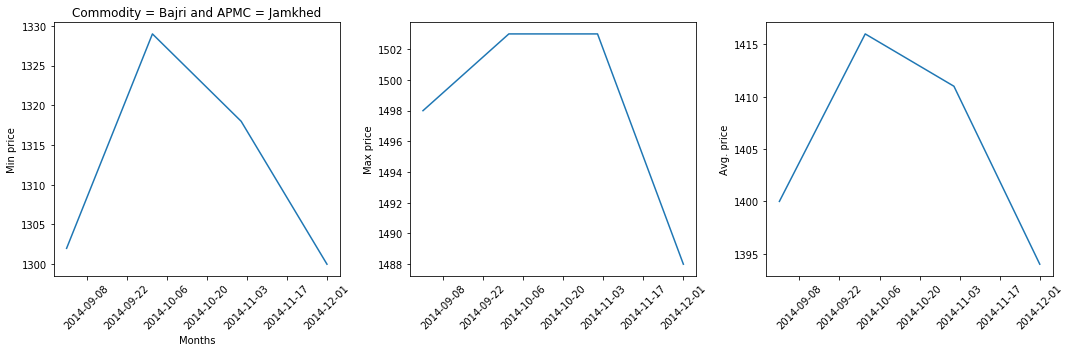

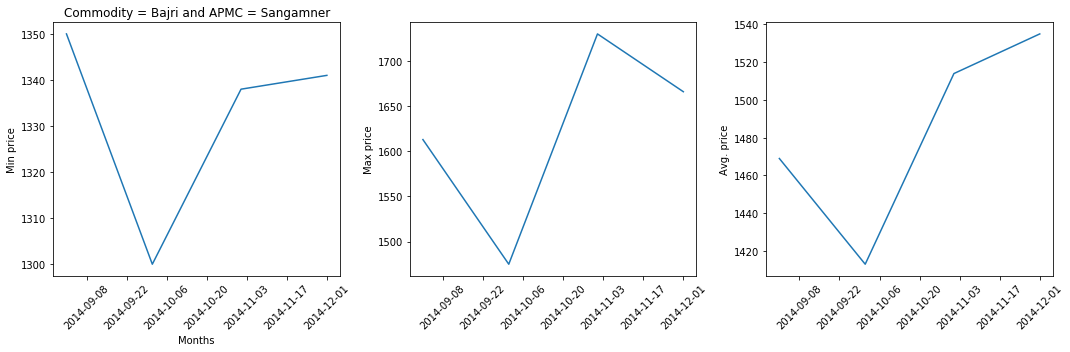

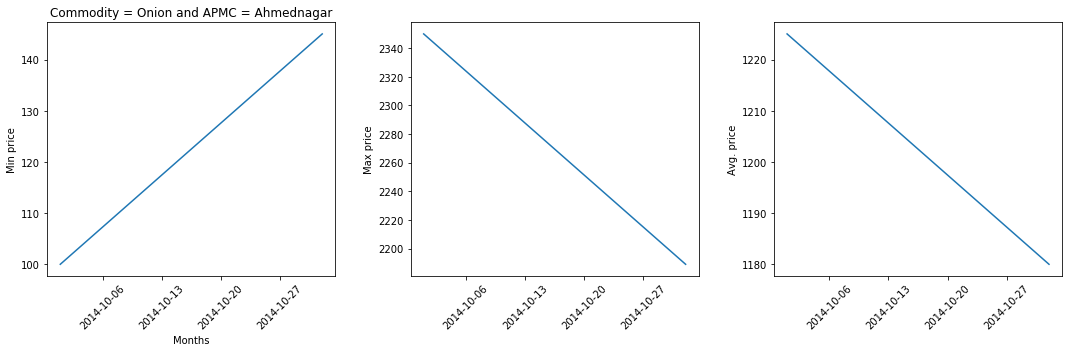

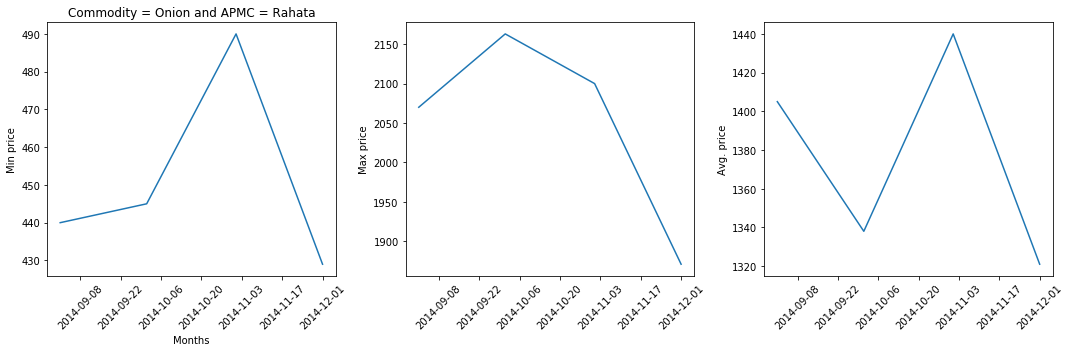

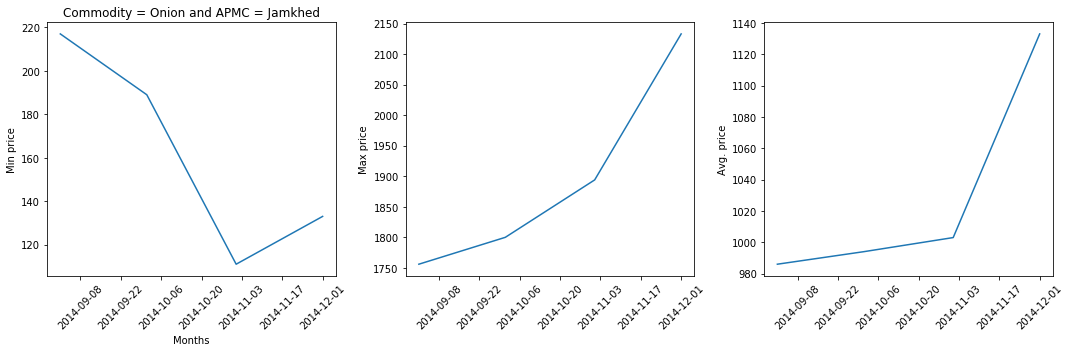

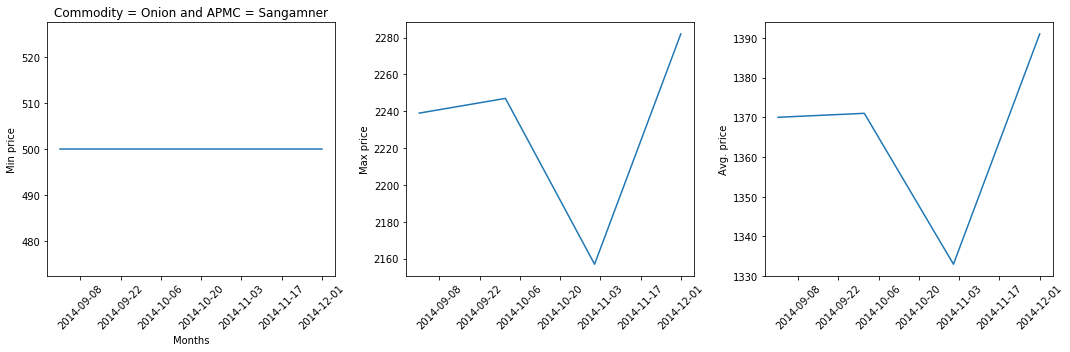

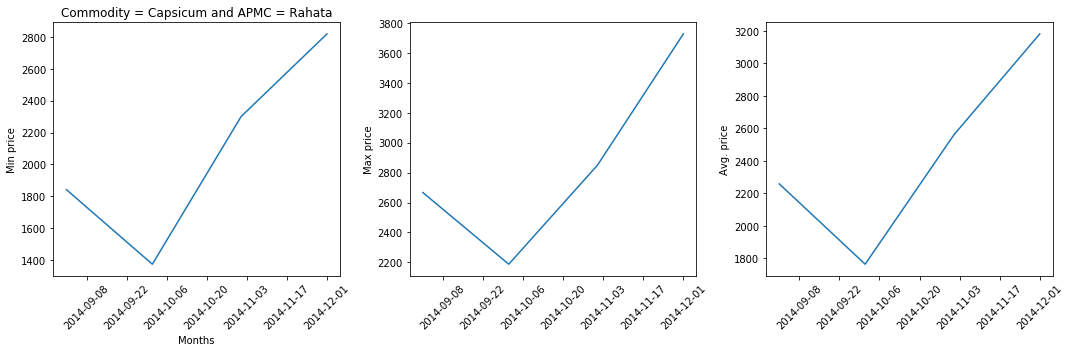

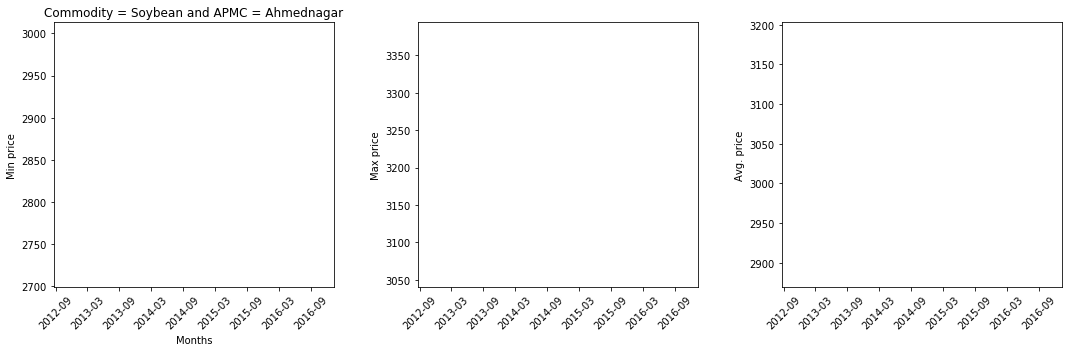

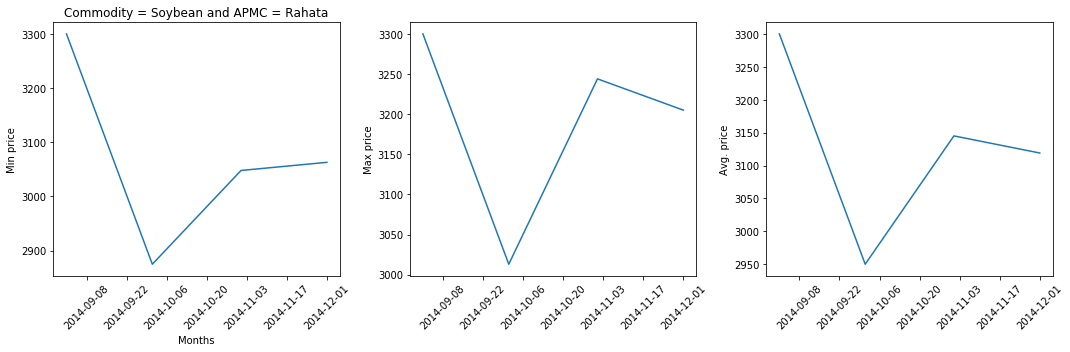

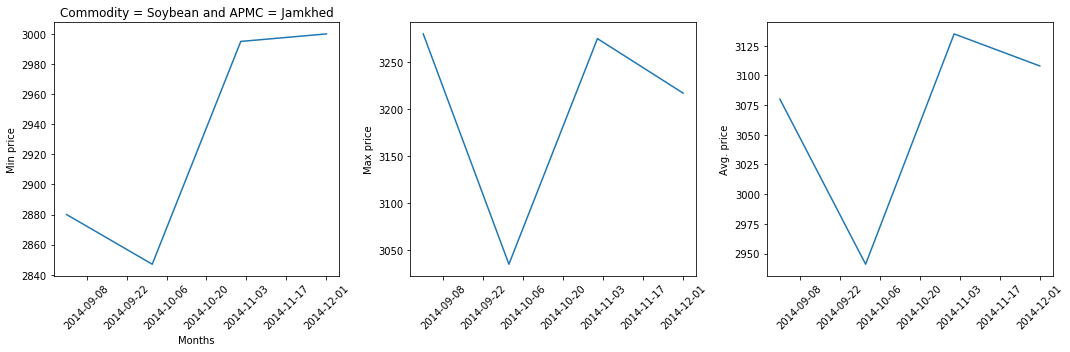

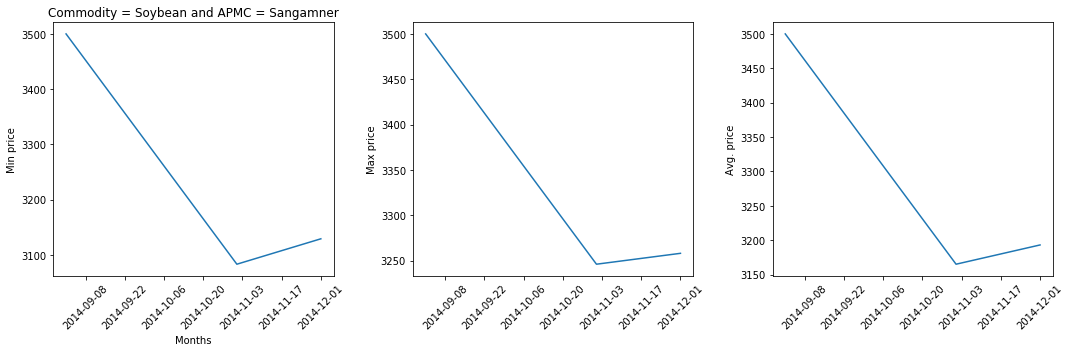

In [110]:
comm_fluctuations = {}
apmc_fluctuations = {}

# For each pair of commodity and APMC, this method computes the Highest Price Fluctuations for the year 2014 by
# differencing the maximum and minimum prices across different months of the year to get the max. price fluctuation.

for c in commodities:
    for apmc in apmcs:
        df_2014_filt = df_2014.query("Commodity=='%s' and APMC=='%s'" % (c, apmc))
        if len(df_2014_filt) == 0:
            continue
        plot_prices_of_commodity(df_2014_filt, c, apmc)
        avg_prices = df_2014_filt['modal_price']
        print('Commodity: %s and APMC: %s' % (c, apmc))
        print('Highest Price Fluctuation (per quintal): %d' % (max(avg_prices) - min(avg_prices)))
        
        if c not in comm_fluctuations:
            comm_fluctuations.update({c: max(avg_prices) - min(avg_prices)})
        else:
            comm_fluctuations[c] = max(comm_fluctuations[c], max(avg_prices) - min(avg_prices))
            
        if apmc not in apmc_fluctuations:
            apmc_fluctuations.update({apmc: max(avg_prices) - min(avg_prices)})
        else:
            apmc_fluctuations[apmc] = max(apmc_fluctuations[apmc], max(avg_prices) - min(avg_prices))

Note: There is no plot for Commodity: Soyabean and APMC: Ahmednagar since there is no prices information of Soyabean in the APMC. 

In [111]:
print(apmc_fluctuations)
print(comm_fluctuations)

{'Ahmednagar': 54, 'Rahata': 1419, 'Jamkhed': 194, 'Sangamner': 335}
{'Bajri': 191, 'Onion': 147, 'Capsicum': 1419, 'Soybean': 350}


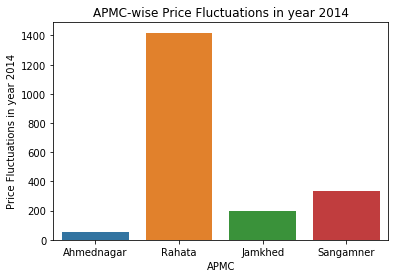

In [112]:
# Visualize Price Fluctuations based on APMCs.

ax = sns.barplot(x = list(apmc_fluctuations.keys()), y = list(apmc_fluctuations.values()))
plt.title('APMC-wise Price Fluctuations in year 2014')
plt.xlabel('APMC')
plt.ylabel('Price Fluctuations in year 2014')
plt.show()

**Analysis:** The above bar plot demonstrates that Rahata APMC suffers from maximum Price Fluctuations in the year 2014.

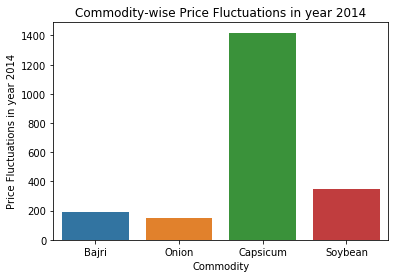

In [113]:
# Visualize Price Fluctuations based on Commodities.

ax = sns.barplot(x = list(comm_fluctuations.keys()), y = list(comm_fluctuations.values()))
plt.title('Commodity-wise Price Fluctuations in year 2014')
plt.xlabel('Commodity')
plt.ylabel('Price Fluctuations in year 2014')
plt.show()

**Analysis:** The above bar plot demonstrates that Capsicum commodity suffers from maximum Price Fluctuations in the year 2014.

So, we can conclude that **APMC: Rahata and Commodity: Capsicum suffer from the highest Price Fluctuations**.

Thank You,

Vibhor